### <center>AI4Brain实验：SSVEP脑机接口数据分析</center>

实验内容：
- 分析一位被试者的SSVEP脑机接口数据，完成分类识别

实验要求：
- 本文件已提供了一个基线算法，请在后文补充你自己实现的机器学习算法
- 包含完整的数据分析过程：算法原理、模型训练、模型验证、模型调优、实验结果分析等
- 提供清晰的图表，必要的代码注释，文字说明等
- 数据集包含受试者的6组数据，要求使用6折交叉验证，即单次训练时选其中5组数据作为训练集，剩下的1组作为验证集；重复6次后，最终得到6次验证结果，计算其平均准确率；如果使用的是无须训练的算法，直接统计6组数据的平均准确率即可；

In [1]:
import numpy as np
import math
import pandas as pd
from numpy import fft

from matplotlib import pyplot as plt
%matplotlib inline

### <center>数据集说明</center>

- 屏幕上的字符数量为40，分成5行8列，每个字符以不同频率闪烁(右下图)
- 包含单个受试者的6组数据，每组数据包含40个trial(分别对应40个字符)
- 单个trial说明：屏幕上随机位置闪烁红色光标(左下图)，引导受试者注视该字符，采样数据记录的是红色光标消失后一小段时间内，受试者持续注视该字符5s的脑电信号
- 数据格式：64个通道，采样频率250Hz，持续时长5s，即包含1250个采样点

<center>
<img src='../image/BCI_01.jpg' style='width: 500px' />
<img src='../image/BCI_10_20_system.png' style='width: 370px' />
</center>

<center>
<img src='../image/BCI_keyboard.jpg' style='width: 400px;margin-right: 20px' />
<img src='../image/BCI_02.jpg' style='width: 400px;' />
</center>


In [2]:
# 加载数据
x = np.load('../data/ssvep.npy')

# 采样率 250Hz
sample_rate = 250

# 6 组数据 * 40 个目标 = 240 个 trial
# 每个 trial 对应 64 个通道的 1250 个采样点(5s * 250Hz)

# Electrode index, Time points, Target index, Block index
n_channel, n_sample, n_target, n_block = x.shape
x.shape

(64, 1250, 40, 6)

In [3]:
# 各通道对应的位置信息
df = pd.read_csv('../data/ssvep_channels.csv')
channels = df['channel'].values
channels

array(['FP1', 'FPZ', 'FP2', 'AF3', 'AF4', 'F7', 'F5', 'F3', 'F1', 'FZ',
       'F2', 'F4', 'F6', 'F8', 'FT7', 'FC5', 'FC3', 'FC1', 'FCz', 'FC2',
       'FC4', 'FC6', 'FT8', 'T7', 'C5', 'C3', 'C1', 'Cz', 'C2', 'C4',
       'C6', 'T8', 'M1', 'TP7', 'CP5', 'CP3', 'CP1', 'CPZ', 'CP2', 'CP4',
       'CP6', 'TP8', 'M2', 'P7', 'P5', 'P3', 'P1', 'PZ', 'P2', 'P4', 'P6',
       'P8', 'PO7', 'PO5', 'PO3', 'POz', 'PO4', 'PO6', 'PO8', 'CB1', 'O1',
       'Oz', 'O2', 'CB2'], dtype=object)

### <center>SSVEP的原理机制</center>

SSVEP = steady-state visual evoked potential, 稳态视觉诱发电位

和视野外围相比，视网膜中央凹的神经元数量更多，与之关联的视觉皮质区域更大，当注视一个指定目标时，会引发较强的VEP响应。

注视一个以固定频率闪烁的目标时，大脑会产生与频率相同的SSVEP信号，这种信号在大脑枕区最为明显。

<center>
<img src='../image/Brain_01.jpg' style='width: 500px;' />
</center>

### <center>SSVEP信号的频率分析</center>
- SSVEP的刺激频率和响应频率，能观察到稳定一致的频率特征
- 通过频谱分析，能观察到明显的基频和谐波峰值，能观察到的谐波上限约为 90 Hz
- 频率-信噪比(SNR)数据来观察谐波信号，比频率-振幅更有效
- 后脑枕区的信号较好，具有最高的振幅和信噪比

<center><img src='../image/BCI_04.jpg' style='width: 500px' /></center>

In [4]:
# 在当前采样频率下，fft变换函数返回的频率列表：0-125Hz, 间隔 0.2 Hz
sample_points = 1250
sample_rate = 250
fs = fft.rfftfreq(sample_points, 1 / sample_rate)
fs[:10], fs[-10:]

(array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2, 1.4, 1.6, 1.8]),
 array([123.2, 123.4, 123.6, 123.8, 124. , 124.2, 124.4, 124.6, 124.8,
        125. ]))

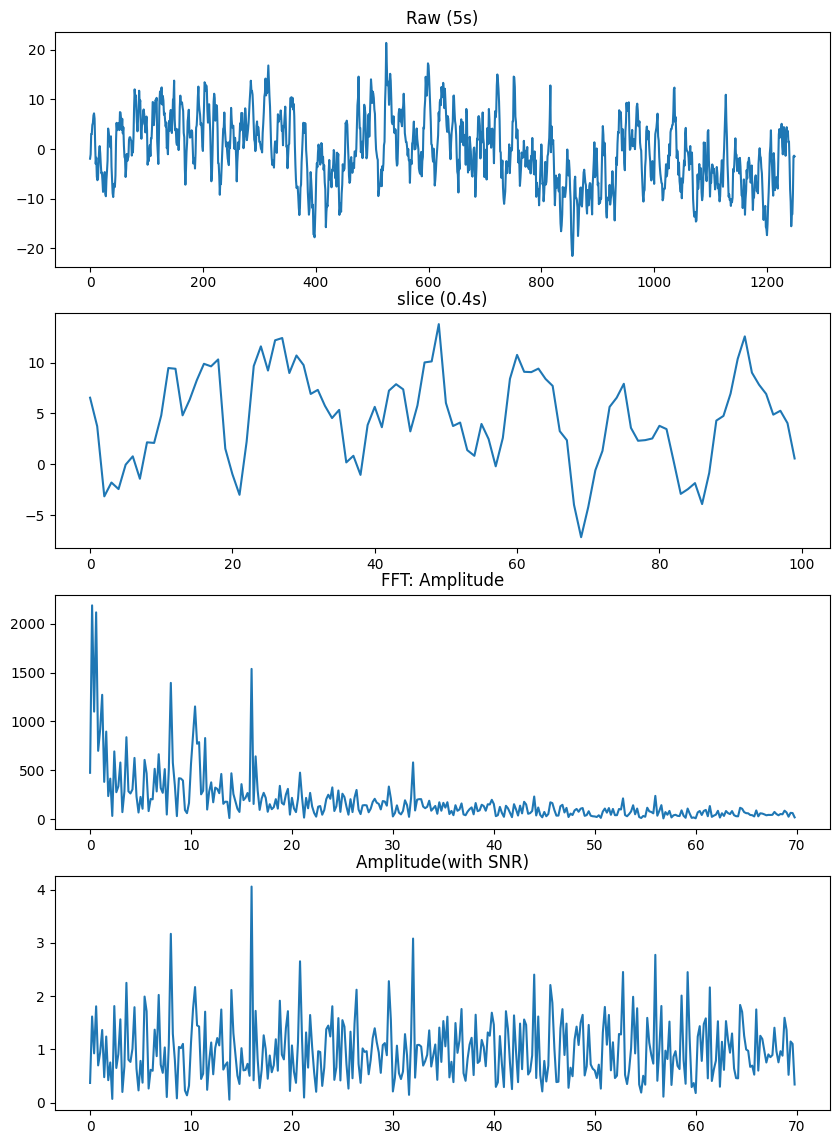

In [5]:
# 选取一组trial数据来观察
# 观看0号字符(坐上角的大写字母A, 以8Hz闪烁), oz电极(通道号61)上的数据
channel_idx = 61
target_idx = 0
block_idx = 0
sample_rate = 250
x1 = x[channel_idx,:,target_idx,block_idx]

# 计算频率和振幅
fs = fft.rfftfreq(x1.size, 1 / sample_rate)
amps = np.abs(fft.rfft(x1))

# 计算频率域的SNR = freq的振幅 / [freq-1, freq+1]范围内的振幅均值
window_size = int(2 / (fs[1] - fs[0])) + 1
k = int(window_size / 2)
y = np.concatenate([amps[:k], amps, amps[-k:]])
weights = np.ones(window_size) / window_size
mean_amps = np.convolve(y, weights, mode='valid')

SNR = amps / mean_amps

plt.figure(figsize=(10, 14))

# 时域图像：
# 1. 原始信号
# 2. 截取的信号小片段，大致能看到 8Hz, 16Hz左右的重复小波形
plt.subplot(411); plt.plot(x1); plt.title('Raw (5s)')
plt.subplot(412); plt.plot(x1[100:200]); plt.title('slice (0.4s)')

# 频域图像：能观察到 8Hz, 16Hz, 32Hz 的峰值
# 3. 频率-振幅
# 4. 频率-信噪比增强后的振幅
flag = (fs < 70)
plt.subplot(413); plt.plot(fs[flag], amps[flag]); plt.title('FFT: Amplitude')
plt.subplot(414); plt.plot(fs[flag], SNR[flag]); plt.title('Amplitude(with SNR)')

plt.show()

In [6]:
# 计算振幅峰值最高的10个频率，由高到低排列
def top_freq_by_amp(x, sample_rate=250):
    fs = fft.rfftfreq(x.size, 1 / sample_rate)
    amps = np.abs(fft.rfft(x))

    results = []
    sort_ids = np.argsort(amps)[::-1]
    for k in sort_ids:
        freq = fs[k]
        if freq < 8 or freq > 90:
            continue

        exist = False
        for v in results:
            if abs(freq - v) < 1.5:
                exist = True
                break
    
        if not exist:
            results.append(freq)
            if len(results) == 10:
                break

    return results

<img src='../image/BCI_02.jpg' style='width: 500px;' />

In [7]:
# 选择不同的字符编号，观察其闪烁的基频和谐波频率
# 观察第一行的6个字符: 8Hz, 9Hz, 10Hz, 11Hz, 12Hz, 13Hz
target_idx = 1
channel_idx = 61
block_idx = 0
for target_idx in range(6):
    ret = top_freq_by_amp(x[channel_idx,:,target_idx,block_idx])
    print(target_idx, ':', np.round(ret, 1))

0 : [16.   8.  10.4 32.  20.8 14.  12.  18.8 29.6 24. ]
1 : [ 9.  10.8 18.  27.  12.8 16.4 20.8 23.  36.  14.8]
2 : [10.   8.4 20.  11.8 14.6 17.4 23.2 40.  32.  30. ]
3 : [11.  12.8 22.2  8.4 16.  18.4 20.  28.2 33.2 24. ]
4 : [12.  10.2 13.6  8.  36.  23.8 15.4 17.6 48.  26. ]
5 : [13.   9.2 11.2 26.  18.4 15.4 39.  20.2 22.4 24.4]


### <center>通过FFT频率分析来确定基频</center>

分析步骤：
- 将实验信号通过FFT转换到频域，计算频谱特征和信噪比(SNR)特征
- 40个字符对应的闪烁频率为 [8 Hz, 15.8 Hz]，分析三个频段 [8, 15.8], [8 \* 2, 15.8 \* 2], [8 \* 3, 15.8 \* 3]
- 在以上频段中，搜寻振幅和信噪比最高的三组数据，计算对应的基频；例如在 [8 \* 3, 15.8 \* 3] 频段中，振幅最高的频率为 30.6 Hz，则预测对应的基频为 30.6 / 3 = 10.2 Hz
- 按上述步骤，对每个信号，得到 2 \* 3 \* 3 条基频预测数据，给定一个权重表，加权求和，得分最高的作为预测的基频

In [8]:
# 从 [8, 15.8], [8, 15.8] * 2, [8, 15.8] * 3 三个范围内
# 寻找振幅最高的3组频率值，和 SNR 最高的3组频率值
def get_base_freq(x, sample_rate = 250):
    fs = fft.rfftfreq(x.size, 1 / sample_rate)
    amps = np.abs(fft.rfft(x))

    target_freq = np.arange(8.0, 16, 0.2)

    # 计算频率域的SNR = freq的振幅 / [freq-1, freq+1]的振幅均值
    window_size = int(2 / (fs[1] - fs[0])) + 1
    k = int(window_size / 2)
    y = np.concatenate([amps[:k], amps, amps[-k:]])
    weights = np.ones(window_size) / window_size
    mean_amps = np.convolve(y, weights, mode='valid')
    SNR = amps / mean_amps

    amp_results = np.zeros((3, 3))
    snr_results = np.zeros((3, 3))

    for scale in [1, 2, 3]:
        low, high = scale * int(8 / 0.2), scale * int(15.8/0.2)

        # 取振幅最高的3个频率
        sort_ids = np.argsort(amps[low:high+1])[::-1]
        idx = 0
        for i in range(5):
            cur_freq = fs[low + sort_ids[i]] / scale

            for f in target_freq:
                if cur_freq - f < 1e-4 and not np.any(amp_results[scale-1] == f):
                    amp_results[scale-1][idx] = f
                    idx += 1
                    break

            if idx == 3:
                break

        # 取SNR最高的3个频率
        sort_ids = np.argsort(SNR[low:high+1])[::-1]
        idx = 0
        for i in range(5):
            cur_freq = fs[low + sort_ids[i]] / scale

            for f in target_freq:
                if cur_freq - f < 1e-4  and not np.any(snr_results[scale-1] == f):
                    snr_results[scale-1][idx] = f
                    idx += 1
                    break

            if idx == 3:
                break

    return amp_results, snr_results

In [9]:
# 测试: 对单个trial的单个通路的信号，进行基频预测分析
target_idx = 2
block_idx = 0
channel_idx = 61

# 返回值：基于频率振幅，SNR振幅，计算出的最强基频
amp_results, snr_results = get_base_freq(x[channel_idx,:,target_idx,block_idx])

amp_results, snr_results

(array([[10. ,  8.4, 11.8],
        [10. , 10.2,  8.8],
        [13.4, 10.8, 10. ]]),
 array([[10. ,  8.4, 15.8],
        [10. , 11.6, 15. ],
        [13.4, 14. , 10.8]]))

In [10]:
# 将 [8, 15.8] 的频率值映射为对应的字符编号
def get_target_id_by_freq(freq):
    if freq < 8:
        return -1
    
    k = math.ceil((freq - 8) / 0.2)
    row = int(k % 5)
    col = int((k - row) / 5)

    return row * 8 + col

# 根据振幅和SNR的基频预测值，加权求和，得到对40组基频数据的评分
def get_scores(f1, f2):
    
    # 加权评分表
    score_table = [
        [6, 4, 2],
        [4, 2, 1],
        [2, 1, 1]
    ]

    scores = np.zeros(40)
    for i in range(3):
        for j in range(3):
            k = get_target_id_by_freq(f1[i][j])
            if k >= 0:
                scores[k] += score_table[i][j]
            
            k = get_target_id_by_freq(f2[i][j])
            if k >= 0:
                scores[k] += score_table[i][j]
    
    return scores

In [11]:
target_idx = 0
block_idx = 0
channel_idx = 61

trial = x[channel_idx,:,target_idx,block_idx]
f_amp, f_snr = get_base_freq(trial)
scores = get_scores(f_amp, f_snr)

# 评分最高的作为预测的基频
freq_list = np.arange(8.0, 16.0, 0.2)

# 观察评分排名靠前的预测值
sort_ids = np.argsort(scores)[::-1]
for i in range(5):
    target = sort_ids[i]

    freq = freq_list[target]

    print(f'[Top {i + 1}] {freq:.2f} Hz, score = {int(scores[target])}')

[Top 1] 8.00 Hz, score = 21
[Top 2] 11.60 Hz, score = 11
[Top 3] 14.80 Hz, score = 4
[Top 4] 10.00 Hz, score = 2
[Top 5] 9.20 Hz, score = 2


<img src='../image/BCI_10_20_system.png' style='width: 400px' />

In [12]:
# 将发现的频率和谐波，加权评分，评分最高的作为基频
block_idx = 0
channel_idx = 61

# 观察64个通道信号单独用于分析的识别准确率
results = []

for channel_idx in range(64):
    right = 0

    for block_idx in range(6):
        for target_idx in range(40):
            trial = x[channel_idx,:,target_idx,block_idx]
            f1, f2 = get_base_freq(trial)
            scores = get_scores(f1, f2)

            answer = np.argmax(scores)

            # 识别正确
            if target_idx == answer:
                right += 1

    results.append(right)

    # print(f'[channel {channel_idx+1}] {100 * right / 40:.1f} %')

# 将所有通道的单通道信号识别准确率，由高到低排列
sort_ids = np.argsort(results)[::-1]

# 准确率最高的15个通道：大都位于后脑枕区
for i in range(15):
    id = sort_ids[i]
    print(f'[channel {id}] [{channels[id]}]\t{100 * results[id] / 240:.1f} %')

[channel 61] [Oz]	73.3 %
[channel 62] [O2]	71.7 %
[channel 63] [CB2]	71.2 %
[channel 56] [PO4]	62.1 %
[channel 55] [POz]	50.4 %
[channel 58] [PO8]	49.2 %
[channel 57] [PO6]	47.5 %
[channel 60] [O1]	46.2 %
[channel 59] [CB1]	45.8 %
[channel 48] [P2]	41.7 %
[channel 49] [P4]	40.8 %
[channel 50] [P6]	40.8 %
[channel 54] [PO3]	30.0 %
[channel 47] [PZ]	27.9 %
[channel 51] [P8]	26.2 %


### <center>SSVEP的各种分析算法</center>

基线算法：
- 无训练，直接通过FFT，计算单通道(Oz)信号的频谱特征，选择振幅最强的基频，能达到 73% 的准确率

传统机器学习：
- 手动计算频谱特征 + 选择一个合适的分类模型：5组训练数据来训练，1组验证数据来验证模型

基于空间滤波的方法：
- canonical correlation analysis (CCA) 
- minimum energy combination (MEC)
- common spatial pattern (CSP)

其它特征提取方法：
- multivariate synchronization index (MSI)
- common feature analysis (CFA)
- likelihood ratio test (LRT)

深度学习的方法：
- 卷积神经网络，图神经网络，GAN等

*【参考论文】A Comparison Study of Canonical Correlation Analysis Based Methods for Detecting Steady-State Visual Evoked Potentials*

CCA 是目前使用最广泛的方法之一，其特点是：效率高、稳定性好、实现简单

## Part 0 : 实验设计中的频率和相位问题

在后续的数据分析中，发现实验设计中的刺激频率和相位有值得注意的点，具体说明如下：

根据实验设计，刺激频率和相位如图所示
<center><img src='../image/BCI_02.jpg' style='width: 500px;' /></center>

观察到：
- 刺激的频率索引是按**列优先**排列的，即第0列是8Hz，第1列是9Hz，第2列是10Hz，依此类推，因此当需要根据频率索引来计算刺激频率时，需注意这一点
- 刺激的相位是按照 JFPM 设计的，即每个刺激频率的相位依次为 [0, π/2, π, 3π/2]，然后下一个频率重新开始

然而，在后续的数据分析中，发现刺激的相位似乎并不是按照上述设计进行的，刺激模式是纯频率编码的，验证如下：

In [13]:
## 在未观察到相位校准前，设计了依据刺激索引获取频率和相位的函数
import numpy as np

def get_freq_phase(target_idx=None):
    """
    根据目标索引获取 SSVEP 刺激频率和相位

    参数:
    - target_idx: 目标索引 (0 到 39 之间的整数)

    返回: (频率, 相位) 元组
    """

    # 定义频率和相位的二维数组（5x8）
    frequencies = np.array([
        [8.0, 9.0, 10.0, 11.0, 12.0, 13.0, 14.0, 15.0],
        [8.2, 9.2, 10.2, 11.2, 12.2, 13.2, 14.2, 15.2],
        [8.4, 9.4, 10.4, 11.4, 12.4, 13.4, 14.4, 15.4],
        [8.6, 9.6, 10.6, 11.6, 12.6, 13.6, 14.6, 15.6],
        [8.8, 9.8, 10.8, 11.8, 12.8, 13.8, 14.8, 15.8]
    ])  # 单位：Hz

    phases = np.array([
        [0.0, 0.5*np.pi, np.pi, 1.5*np.pi, 0.0, 0.5*np.pi, np.pi, 1.5*np.pi],
        [0.5*np.pi, np.pi, 1.5*np.pi, 0.0, 0.5*np.pi, np.pi, 1.5*np.pi, 0.0],
        [np.pi, 1.5*np.pi, 0.0, 0.5*np.pi, np.pi, 1.5*np.pi, 0.0, 0.5*np.pi],
        [1.5*np.pi, 0.0, 0.5*np.pi, np.pi, 1.5*np.pi, 0.0, 0.5*np.pi, np.pi],
        [0.0, 0.5*np.pi, np.pi, 1.5*np.pi, 0.0, 0.5*np.pi, np.pi, 1.5*np.pi]
    ])  # 单位：rad

    if target_idx is None:
        # 返回展平后的全部频率和相位
        return frequencies.flatten(), phases.flatten()
    else:
        if not isinstance(target_idx, int) or target_idx < 0 or target_idx >= 40:
            raise ValueError("target_idx 必须是 0 到 39 之间的整数")
        row = target_idx // 8
        col = target_idx % 8

    freq = frequencies[row, col]
    phase = phases[row, col]

    return freq, phase

## 然而经过验证（见下一个单元格），实验刺激模式并非如图所示的 JFPM，而是纯频率调制（FM, Frequency Modulation）格式，因此重新写了新的函数
## 该函数封装在 src/preprocess/preprocessing.py 中
def get_freqs(target_idx=None):

    """
    根据目标索引获取 SSVEP 刺激频率列表

    参数:
    - target_idx: 目标索引 (0 到 39 之间的整数)，可选

    返回: 频率数组
    """

    freqs = []
    for offset in np.arange(0.0, 1.0, 0.2):
        for base in np.arange(8.0, 16.0, 1.0):
            freqs.append(round(base + offset, 1))
    if target_idx is not None:
        if not isinstance(target_idx, int) or target_idx < 0 or target_idx >= 40:
            raise ValueError("target_idx 必须是 0 到 39 之间的整数")
        return freqs[target_idx]

    return np.array(freqs)

### 原理

#### 基本思想

- 把每个刺激频率对应的 EEG 响应在该频点的相位取出来
- 对相位随频率的关系做**线性拟合**
- 看拟合优度（**R²**）是不是接近 1
- 并对 **拟合后的残余相位** 做统计检验（Shapiro），看残余是否“像噪声”（正态、无结构）

如果相位与频率非常线性，残差又“随机”，那就可以说明：系统只是在频率上编码，不需要额外设置每个频率的相位参数

#### 数学原理
如果真实响应可以近似为：

$$
x_k(t)=A_k\sin(2\pi f_k(t-\tau)+\phi_0)
$$

也就是所有频率都有一个共同的延迟 $\tau$（视觉-神经-采集链路造成），那么在频域上对应的相位会是：

$$
\phi(f_k) = -2\pi f_k \tau + \phi_0
$$

这就是一个关于 $f$ 的线性函数：

* 斜率 $a = -2\pi\tau$
* 截距 $b = \phi_0$

所以：如果看到 $\phi$ 和 $f$ 非常线性，就意味着纯频率编码解释得通

R² = 0.999625
Shapiro-Wilk 正态性检验 p-value = 0.647373


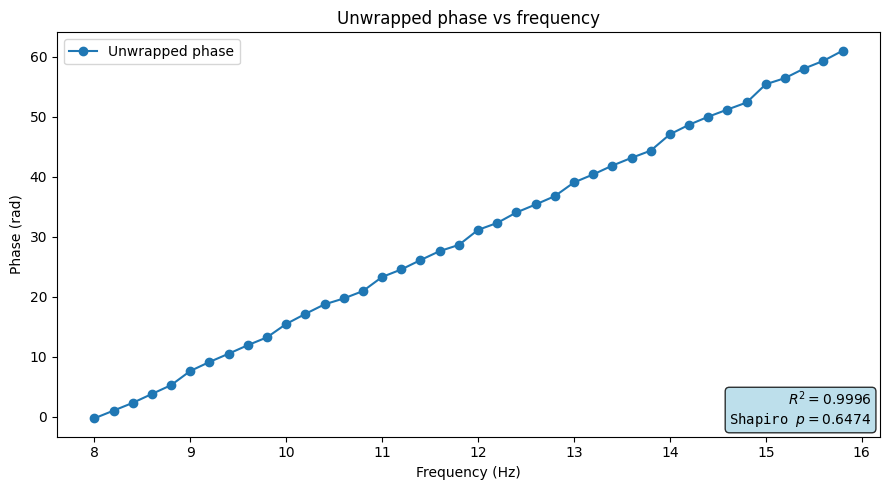

In [14]:
import numpy as np
from scipy.stats import pearsonr, shapiro
from scipy.fft import fft, fftfreq
import matplotlib.pyplot as plt
import sys
import os
sys.path.append(os.path.abspath('..'))
from src.preprocess.preprocessing import preprocess_data

# 这里的preprocess_data函数用于对原始数据进行预处理，如滤波、去伪迹等，是在后续分析过程中写下并封装的，但是尚未展示
# 但可以理解为对原始EEG数据进行了一些标准的预处理操作，以提高后续分析的准确性和可靠性

def analyze_ssvep_frequency_phase(raw_data, stim_freqs, fs, channel_idx=61, show_plots=True):
    """
    对 SSVEP 频率与相位关系执行分析，评估线性拟合优度与残余相位正态性

    参数:
        raw_data (np.ndarray): 原始 EEG 数据，维度为 (通道数, 时间点, 目标数, 试次块数)
        stim_freqs (np.ndarray): 刺激频率列表
        fs (float): 采样频率（Hz）
        channel_idx (int): 待分析通道索引（例如 Oz 通道）
        show_plots (bool): 是否显示结果图
    返回:
        freqs_sorted (np.ndarray): 排序后的频率列表
        phases_sorted (np.ndarray): 排序后的相位列表
    """
    # --- 1. 对原始数据进行预处理 ---
    preprocessed_data = preprocess_data(raw_data, fs=fs)
    
    # --- 2. 对试次块取平均，生成高 SNR 试次 ---
    avg_data = np.mean(preprocessed_data, axis=-1)  # 形状: (通道数, 时间点, 目标数)
    
    # --- 3. 在干净数据上执行 FFT ---
    N_TIME_POINTS = avg_data.shape[1]
    phases = []
    
    
    for i in range(len(stim_freqs)):
        # 提取目标刺激与指定通道的干净信号
        clean_signal = avg_data[channel_idx, :, i]
        
        # 执行快速傅里叶变换（FFT）
        fft_vals = fft(clean_signal)
        fft_freqs = fftfreq(N_TIME_POINTS, d=1/fs)
        
        # 找到最接近目标频率的频点索引
        target_freq = stim_freqs[i]
        idx = np.argmin(np.abs(fft_freqs - target_freq))
        
        # 从该频点提取相位
        phase_rad = np.angle(fft_vals[idx])
        phases.append(phase_rad)

    phases = np.array(phases)
    
    sort_indices = np.argsort(stim_freqs)
    freqs_sorted = stim_freqs[sort_indices]
    phases_sorted = phases[sort_indices]

    # --- 1) unwrap + 线性拟合 ---
    phi_unwrap = np.unwrap(phases_sorted)
    # polyfit: phi ≈ a*f + b
    a, b = np.polyfit(freqs_sorted, phi_unwrap, deg=1)

    # 拟合趋势
    phi_fit = a * freqs_sorted + b

    # --- 2) 去除趋势后的残余相位（wrap到[-pi, pi]） ---
    # 用复指数方式wrap最稳
    residual_phase = np.angle(np.exp(1j * (phi_unwrap - phi_fit)))

    # 1. 检查拟合优度
    r_squared = pearsonr(freqs_sorted, phi_unwrap)[0]**2
    print(f"R² = {r_squared:.6f}")

    # 如果 R² > 0.99，基本可以确定是纯频率编码
    # 如果 R² < 0.95，说明有显著的非线性成分（可能是相位编码）

    # 2. 统计检验残差是否显著
    _, p_value = shapiro(residual_phase)
    print(f"Shapiro-Wilk 正态性检验 p-value = {p_value:.6f}")

    if show_plots:
        plt.figure(figsize=(9, 5))

        # unwrap相位与线性拟合
        plt.plot(freqs_sorted, phi_unwrap, "o-", label="Unwrapped phase")
        plt.xlabel("Frequency (Hz)")
        plt.ylabel("Phase (rad)")
        plt.title("Unwrapped phase vs frequency")
        plt.legend()

        ax = plt.gca()
        textstr = f'$R^2 = {r_squared:.4f}$\nShapiro $p = {p_value:.4f}$'
        props = dict(boxstyle='round', facecolor='lightblue', alpha=0.8, edgecolor='black')
        ax.text(0.99, 0.02, textstr,
                transform=ax.transAxes,
                verticalalignment='bottom',
                horizontalalignment='right',
                bbox=props,
                fontsize=10,
                fontfamily='monospace')  # 更清晰的字体

        plt.tight_layout()
        plt.show()

    return freqs_sorted, phases_sorted


if __name__ == '__main__':
    # --- 加载数据与参数 ---
    FS = 250
    DATA_PATH = "../data/ssvep.npy"
    x = np.load(DATA_PATH)
    
    freqs = get_freqs()

    freqs_sorted, phases_sorted = analyze_ssvep_frequency_phase(
        raw_data=x,
        stim_freqs=freqs,
        fs=FS,
        channel_idx=61,  # Oz 通道
        show_plots=True
    )

### 结果分析

* $R^2 = 0.9996$（极高）
* Shapiro $p = 0.6474$（显著大于 0.05）

也就是说：
$$
\phi(f) \approx af+b
$$

证明不同频率之间的相位差是由共同延迟 $\tau$ 自动产生的，且p=0.6474 说明不能拒绝“残差来自正态分布”的假设，这意味着去掉线性趋势后，剩下的相位抖动更像“测量噪声/非锁相成分”，而不是“可重复的相位编码”，因此可以认为：**刺激是纯频率编码的**，而不是 JFPM 设计的那样有额外相位编码。

## <center>Part I: 数据预处理</center>
EEG数据常受 ***伪迹（artifacts）*** 污染，需进行标准化预处理以提升信号质量。通过阅读相关文献，在本实验采用以下预处理流程：

### 1. Re-referencing 重参考
**共同平均参考（Common Average Reference, CAR）** 作为抑制共模噪声（common-mode noise）的核心空间滤波器，其原理在于：通过计算所有通道的平均信号构造虚拟参考点，从各通道中减去该参考信号，从而消除空间分布广泛的噪声（如工频干扰）。CAR的数学表达为：
$$
\mathbf{x}_{\text{car}}(t) = \mathbf{x}(t) - \frac{1}{N_{\text{ch}}} \sum_{i=1}^{N_{\text{ch}}} \mathbf{x}_i(t),
$$
其中 $\mathbf{x}(t)$ 为原始信号向量，$\mathbf{x}_{\text{car}}(t)$ 为CAR处理后的信号，$N_{\text{ch}}$ 为通道数
- SSVEP-BCI数据主要噪声源来自于工频干扰（50/60Hz），这是是典型的共模噪声，它在所有电极上几乎是同相位的，CAR能极其有效地将其消除。

> 在进行CAR之前，需先进行 **坏通道检测（Bad Channel Detection）**，以剔除质量极差的通道，避免其对CAR参考信号的负面影响

#### 坏通道检测
- 原理：基于 **通道标准差（Channel Standard Deviation）** 与**四分位距（Interquartile Range, IQR）** 的统计异常检测方法
    - 通道标准差：计算每个通道在整个时间序列上的标准差来评估信号质量，Std 很大代表高噪声，Std 很小代表电极脱落
    - IQR - Interquartile Range：IQR是中间 50% 数据的范围，可以通过阈值 threshold （$\theta$）和 IQR 定义上下边界，进行动态双边界检测，可以识别过度活跃（噪声）和微弱信号（脱落），默认 $\theta = 1.5$，可以调整以观察效果
  $$
  \text{Lower bound} = Q_1 - \theta \cdot \text{IQR}, \quad \text{Upper bound} = Q_3 + \theta \cdot \text{IQR}.
  $$
- 实现：计算每个通道的 Std 和 IQR，若某通道的 Std 超出 IQR 上下边界，则标记为坏通道
    
### 2. Band Pass Filter 带通滤波
> A band-pass filter allows through components in a specified band of frequencies, called its passband but blocks components with frequencies above or below this band.
带通滤波器允许特定频带（称为通带）中的分量通过，但屏蔽高于或低于该频带的分量。

#### 切比雪夫滤波器（Chebyshev Filter）

切比雪夫滤波器（Chebyshev Filter）是一类在通带或阻带具有等波纹特性的模拟/数字滤波器，常用于需要陡峭过渡带的场景。根据波纹所在区域，分为 **Chebyshev I 型**（通带波纹、阻带平坦）和 **Chebyshev II 型**（通带平坦、阻带波纹）。在脑电（EEG）信号处理中，**Chebyshev I 型** 更为常用。

在SSVEP-BCI任务中，Chebyshev 带通滤波器因其优异的频率选择性而被采用，其关键特性如下：

| 特性 | 作用 | 生物物理依据 |
|------|------|--------------|
| **陡峭的过渡带** | 在通带边缘实现快速衰减，有效分离目标频段与邻近干扰（如相邻刺激频率） | SSVEP刺激频率通常密集排布（如8.0, 8.6, 9.2 Hz…），需高频率分辨率避免串扰（Zhang et al., 2019） |
| **通带等波纹（Chebyshev I型）** | 允许通带内小幅幅度波动，换取更窄的过渡带宽 | 虽引入轻微幅度失真，但SSVEP识别主要依赖频率特征（如CCA/TRCA匹配模板频率），对幅度平坦性容忍度较高 |
| **可调波纹参数（Ripple）** | 通过调节通带波纹量（如0.5 dB）平衡选择性与信号保真度 | 小波纹（30 Hz） |
| **配合零相位实现（`filtfilt`）** | 双向滤波消除相位延迟，保留SSVEP的时域锁相特性 | 相位一致性是TRCA等时域方法的核心前提；相位失真会显著降低模板匹配精度[1] |

> **典型应用示例**：在8–60 Hz SSVEP实验中，采用 Chebyshev I 型带通滤波器（通带8–60 Hz，通带波纹0.5 dB，阶数4–6），可有效保留基频及其前4–6次谐波能量，同时强力抑制眼电（60 Hz）及50 Hz工频干扰，显著提升FBCCA与TRCA的分类性能。
> **注意事项**：由于通带存在波纹，若后续分析高度依赖精确幅度（如功率谱绝对值比较），建议优先选用Butterworth滤波器；若侧重频率分辨与噪声抑制，则Chebyshev更具优势。


### 3.陷波滤波 (Notch Filter)

陷波滤波器（Notch Filter）是一种**窄带阻滤波器（narrowband stop-band filter）**，其核心功能是在频域中**高度选择性地抑制某一特定频率及其极窄邻域内的成分**，同时对其他频率成分几乎无影响。在SSVEP-BCI研究中，陷波滤波器主要用于**消除工频干扰（power-line interference）**，即50 Hz（中国、欧洲等）或60 Hz（北美等）的交流电噪声。

> 工频干扰具有以下特征：
> - **高幅值**（可达数十微伏，而SSVEP通常<5 μV）
> - **频谱尖锐、稳定**，表现为单一频率正弦成分
> - **非神经起源**，属于共模噪声

最常用的陷波滤波器为**二阶无限冲激响应（Infinite Impulse Response, IIR）结构**，其传递函数为：
$$H(z) = \frac{1 - 2\cos(2\pi f_0 / f_s) z^{-1} + z^{-2}}{1 - 2r\cos(2\pi f_0 / f_s) z^{-1} + r^2 z^{-2}},$$
其中：
- $\omega_0 = 2\pi f_0 / f_s$ 为归一化陷波中心角频率（$f_0$ 为工频，如50 Hz；$f_s$ 为采样率）；
- $r \in (0,1)$ 控制**带宽（Bandwidth, BW）**，与品质因数（Quality Factor, $Q$）关系为  
  $$
  Q = \frac{f_0}{\mathrm{BW}} \approx \frac{1}{2(1 - r)}.
  $$

在实际实现中（如SciPy的 `iirnotch`），可以直接指定 $f_0$ 和 $Q$，默认 $Q=30$ 对应带宽约1.67 Hz，足以抑制工频而不损伤邻近神经频段


[1]Nakanishi, M., Wang, Y., Chen, X., Wang, Y. T., Gao, X., & Jung, T. P. (2018). Enhancing Detection of SSVEPs for a High-Speed Brain Speller Using Task-Related Component Analysis. IEEE transactions on bio-medical engineering, 65(1), 104–112. https://doi.org/10.1109/TBME.2017.2694818

Stats: Q1=4.93, Q3=8.56, IQR=3.63, Upper Bound=15.81
Bad Channels found: []
Total Good Channels: 64
Stats: Q1=4.93, Q3=8.56, IQR=3.63, Upper Bound=17.62
Bad Channels found: []
Total Good Channels: 64
Stats: Q1=4.93, Q3=8.56, IQR=3.63, Upper Bound=19.44
Bad Channels found: []
Total Good Channels: 64
Stats: Q1=4.93, Q3=8.56, IQR=3.63, Upper Bound=21.25
Bad Channels found: []
Total Good Channels: 64


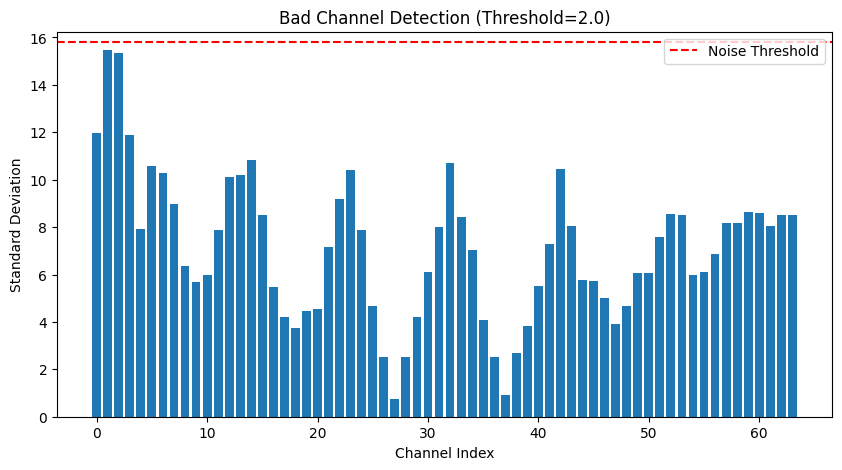

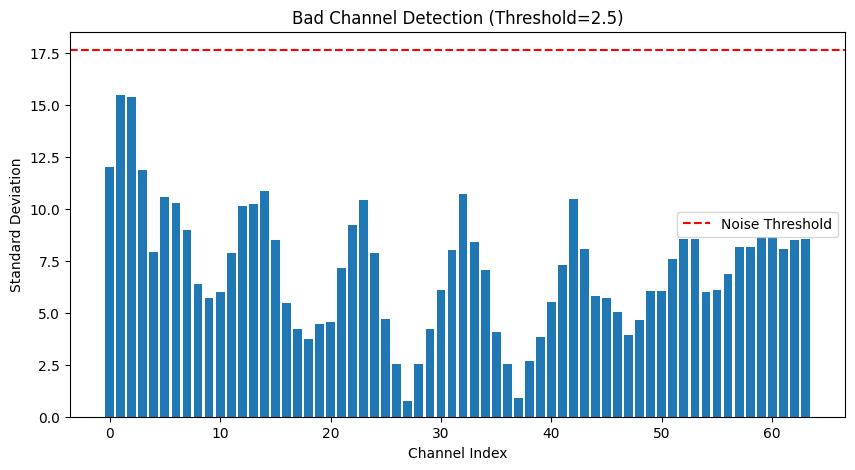

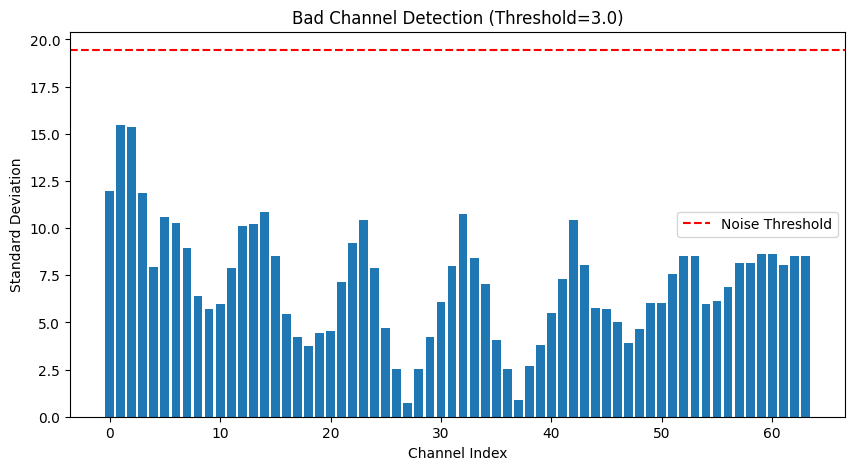

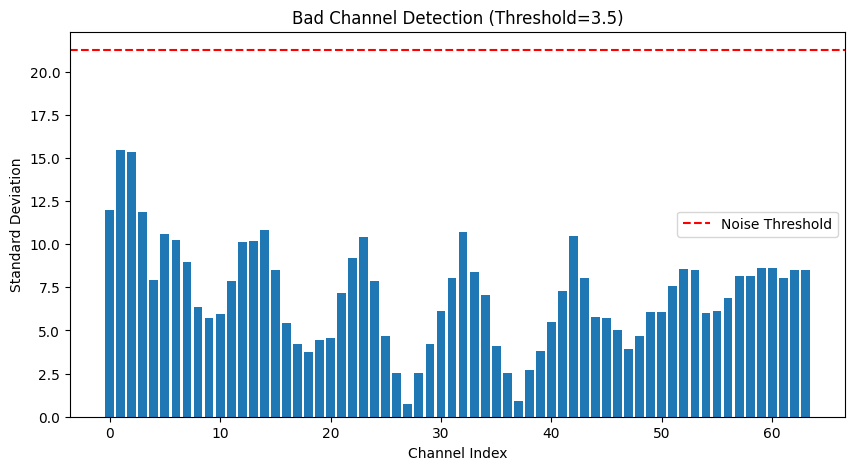

In [15]:
### 检测坏通道（Detect Bad Channels）
import numpy as np
import matplotlib.pyplot as plt

def detect_bad_channels(data, threshold=1.5):
    """
    使用 IQR 方法基于通道标准差检测坏通道
    
    参数:
        data: 形状为 (通道数, 时间点数, ...) 的数组
        threshold: IQR 的倍数阈值，默认 1.5
    返回:
        good_indices: 正常通道的索引列表
        bad_indices: 坏通道的索引列表
    """
    # 1. 将数据展平，把所有试次和轮次拼接成一个长序列（每通道一条时间序列）
    # 新形状: (64, 1250 * 40 * 6) = (64, 300000)
    flat_data = data.reshape(n_channel, -1)
    
    # 2. 计算每个通道的标准差
    # 标准差反映该通道信号的“能量”或“活跃程度”
    channel_stds = np.std(flat_data, axis=1)
    
    # 3. 计算四分位数统计量
    Q1 = np.percentile(channel_stds, 25)  # 第一四分位数（25%）
    Q3 = np.percentile(channel_stds, 75)  # 第三四分位数（75%）
    IQR = Q3 - Q1                         # 四分位距（Interquartile Range）
    
    # 4. 定义上下阈值
    # 上界：用于检测高幅值噪声（如肌电、电源干扰）
    upper_bound = Q3 + (threshold * IQR) # 基于数据分布动态计算“高能量异常值”的统计上界
    # 下界：用于检测“死通道”（信号几乎为零，如电极脱落）
    lower_bound = Q1 - (threshold * IQR)  # 基于数据分布动态计算“低能量异常值”的统计下界
    lower_bound = max(lower_bound, 1e-5)  # 防止下界为负数
    
    # 5. 找出坏通道和好通道的索引
    bad_indices = np.where((channel_stds > upper_bound) | (channel_stds < lower_bound))[0]
    good_indices = np.where((channel_stds <= upper_bound) & (channel_stds >= lower_bound))[0]
    
    # 打印统计信息
    print(f"Stats: Q1={Q1:.2f}, Q3={Q3:.2f}, IQR={IQR:.2f}, Upper Bound={upper_bound:.2f}")
    print(f"Bad Channels found: {bad_indices}")
    print(f"Total Good Channels: {len(good_indices)}")
    
    # 绘制柱状图，可视化各通道标准差及阈值
    plt.figure(figsize=(10, 5))
    plt.bar(range(n_channel), channel_stds)
    plt.axhline(y=upper_bound, color='r', linestyle='--', label='Noise Threshold')
    plt.xlabel('Channel Index')
    plt.ylabel('Standard Deviation')
    plt.title(f'Bad Channel Detection (Threshold={threshold})')
    plt.legend()
    # plt.savefig(f'{FIGURE_SAVE_DIR}bad_channel_detection_threshold_{threshold}.png')
    
    return good_indices, bad_indices


# 加载数据
data = np.load(DATA_PATH)
# 数据形状: (64, 1250, 40, 6)
n_channel, n_sample, n_target, n_block = data.shape 

# 检测坏通道
for threshold in [2.0, 2.5, 3.0, 3.5]:
    good_ch, bad_ch = detect_bad_channels(data, threshold=threshold)

#### 坏通道检测结果
当 <code>threshold</code> 设置为2.0、2.5、3.0、3.5时，均未检测到坏通道，因此数据可全部进行 CAR 预处理
<div style="text-align: center;">
  <img src='../image/bad_channel_detection_threshold_2.0.png' style='width: 45%; height: 300px; display: inline-block; margin: 0 1%;' />
  <img src='../image/bad_channel_detection_threshold_2.5.png' style='width: 45%; height: 300px; display: inline-block; margin: 0 1%;' />
</div>

<div style="text-align: center;">
  <img src='../image/bad_channel_detection_threshold_3.0.png' style='width: 45%; height: 300px; display: inline-block; margin: 0 1%;' />
  <img src='../image/bad_channel_detection_threshold_3.5.png' style='width: 45%; height: 300px; display: inline-block; margin: 0 1%;' />
</div>


#### 注意
由于绘图的代码与算法原理以及实验内容关系不大，但其回占据 notebook cell 的大量空间，因此所有的绘图代码均封装至 <code>src/visualization</code> 中以便调用

In [16]:
# src/config.py
import numpy as np

# ===============
# SSVEP 数据集配置
# ===============

class Config:
    # 实验参数                   
    FS = 250                      # 采样频率（Hz）
    CHANNELS = [47, 53, 54, 55, 56, 57, 60, 61, 62]       # 优化后的通道选择
    N_TARGETS = 40                # SSVEP 目标刺激数量
    N_BLOCKS = 6                  # 每个目标的实验块数（block 数）                      
    GAZE_SHIFT = 0.50             # 眼动移位
    WINDOW_START = 0.14           # 起始时间（秒）
    TRIAL_DURATION = 5.0          # 每个 trial 的持续时间（秒）
    SAMPLE_POINTS = int(FS * TRIAL_DURATION)  # 每个 trial 的采样点数
    
    # 滤波参数
    BANDPASS_LOW = 7.0            # 带通滤波低频截止（Hz）
    BANDPASS_HIGH = 90.0          # 带通滤波高频截止（Hz）
    NOTCH_FREQ = 50.0             # 工频陷波频率（Hz）
    NOTCH_Q = 30.0                # 陷波器品质因数
    
    # 分析参数
    MAX_DURATION = TRIAL_DURATION - WINDOW_START  # 最大可用持续时间（秒）
    DURATION_MIN = 0.2                            # 最小持续时间（秒）
    DURATION_STEP = 0.2                           # 持续时间步长（秒）
    DURATION_RANGE = None                         # 初始化后赋值
    
    FIXED_DURATION = 1.25         # 根据 Chen et al.(2015)  的研究优化得出
    
    NH_RANGE = list(range(1, 11))                 # 谐波数量范围
    A_RANGE = np.arange(0, 2.25, 0.25)            # 权重参数 a 范围
    B_RANGE = np.arange(0, 1.25, 0.25)            # 权重参数 b 范围
    N_SB_RANGE = list(range(1, 11))               # 子带数量范围
    
    @classmethod
    def initialize_duration_range(cls):
        cls.DURATION_RANGE = np.arange(cls.DURATION_MIN, 
                                       cls.MAX_DURATION - 1.0, 
                                       cls.DURATION_STEP)

### <center>Part I: 数据预处理和效果可视化</center>

基于前文所述原理，本节实现了具体的预处理流程，并对处理前后的信号进行可视化对比，以验证算法有效性

1.  **坏通道剔除**：基于 IQR 准则检测并剔除异常高幅值通道。
2.  **全脑共平均参考 (Global CAR)**：计算 64 通道的平均值作为参考信号，消除全脑共模噪声（如设备电磁干扰）：
3.  **陷波滤波 (Notch Filter)**：使用 IIR 陷波滤波器（$Q=30$）精准去除 **50 Hz** 工频干扰及其对高频谐波的潜在污染。
4.  **宽带带通滤波**：应用 4-60 Hz 四阶 Butterworth 滤波器，滤除低频漂移（$<4 \text{ Hz}$）和高频肌电伪迹（$>60 \text{ Hz}$），同时保留 SSVEP 的基频及主要谐波成分。
5.  **ROI 选择**：选取枕叶区域的 9 个关键通道（Pz, PO3, PO5, PO4, PO6, POz, O1, Oz, O2）进行后续分析（后续进行通道选择的敏感性分析）

**函数：**
- **`apply_spatial_filter_car`**: 计算所有（良性）通道的平均值作为参考信号，从每个通道中减去该参考，以抑制全局共模噪声。
- **`butter_bandpass_filter`**: 设计 4 阶 Butterworth 滤波器，通带范围设为 **6Hz - 90Hz**
    - **下限 6Hz**: 去除低频漂移（<1Hz）和极低频伪迹，同时保留最低刺激频率（8Hz）的完整性。
    - **上限 90Hz**: 覆盖 SSVEP 信号的主要谐波区间同时滤除高频肌电噪声
- **`apply_notch_filter`**: 设计 IIR 陷波滤波器，去除 **50 Hz** 工频干扰，品质因数设为 **Q=30**

**可视化验证目标：**
选取 **Oz 通道**（枕叶视觉区核心电极）在 **Target 1 (9Hz)** 刺激下的数据：
1. **时域对比**: 观察信号基线漂移的校正情况。
2. **频域对比**: 确认 50Hz 工频干扰是否被抑制，以及 9Hz 基频及其谐波（18Hz, 27Hz...）的峰值是否更加显著

Visualizing Target 1 at Channel 61（9.0Hz）


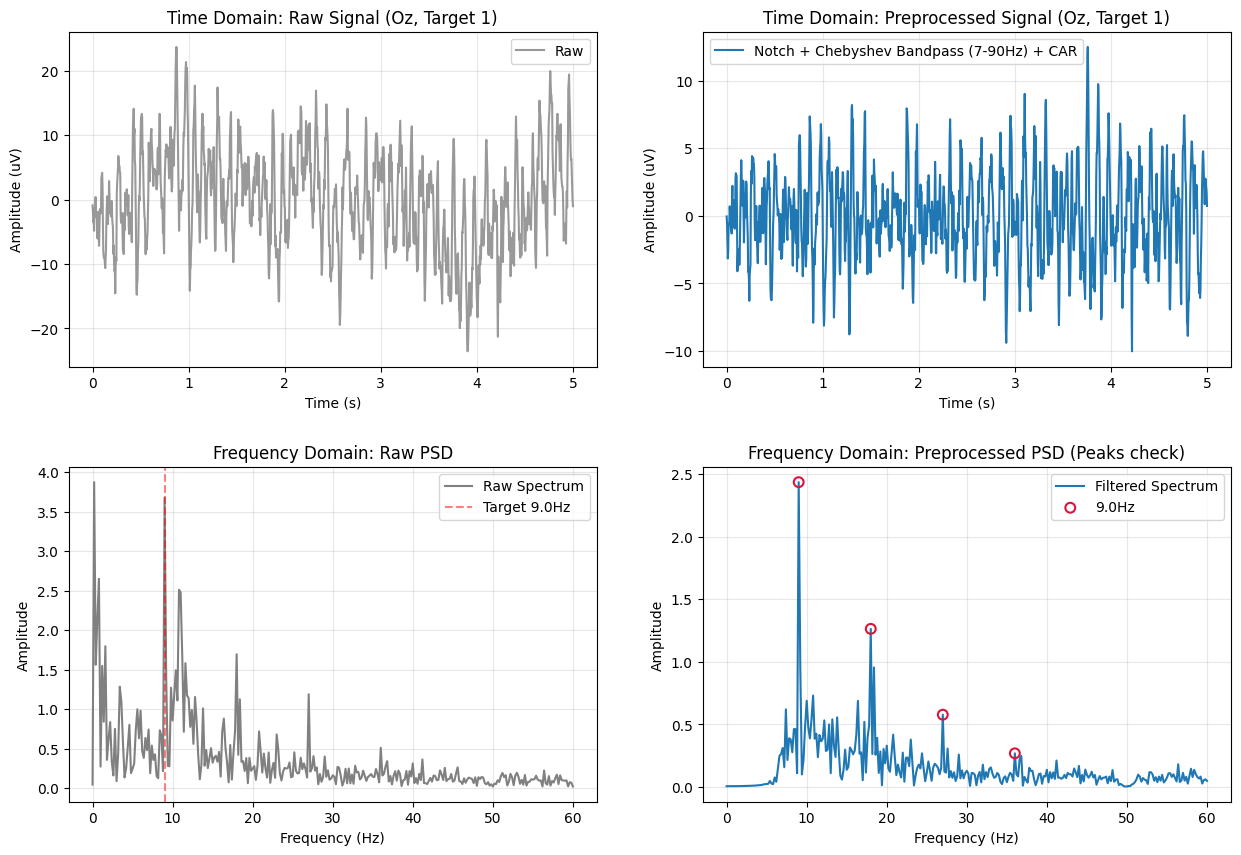

In [17]:
# 数据预处理与可视化（Signal Preprocessing and Visualization）
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
from numpy import fft
import sys
import os
sys.path.append(os.path.abspath('..'))
from src.preprocess.preprocessing import cheby_bandpass_filter
from src.config import Config

cfg = Config()


# 1. 定义预处理函数
def apply_spatial_filter_car(data, good_indices=None):
    """
    应用修正后的共平均参考（CAR）：
    仅使用好通道计算平均参考信号，避免坏通道污染。
    
    参数:
        data: 原始数据，形状 (n_channel, ...)
        good_indices: 好通道的索引列表
    返回:
        经过 CAR 处理后的数据，形状与输入相同
    """
    # 1. 仅选取好通道用于计算平均参考
    if good_indices is not None:
        subset_data = data[good_indices, ...]
    else:
        subset_data = data
    
    # 2. 在正常通道上沿通道维度求平均（保留维度以便广播）
    common_average = np.mean(subset_data, axis=0, keepdims=True)
    
    # 3. 从所有通道（包括坏通道）中减去这个“干净”的平均参考信号
    return data - common_average

def apply_notch_filter(data, freq, fs, quality_factor=30):
    """
    应用陷波滤波器（Notch Filter）去除特定频率的工频干扰（如 50Hz 或 60Hz）。
    
    参数:
        data: 输入数据，形状 (n_channels, n_time_points) 或 (n_time_points,)
        freq: 需要去除的中心频率 (Hz)，例如 50.0
        fs: 采样频率 (Hz)
        quality_factor (Q): 质量因子，决定了滤波器的带宽。
                            Q = 中心频率 / 带宽。
                            Q=30 在 50Hz 时意味着带宽约为 1.7Hz (49.15-50.85Hz)，
                            既能有效去噪又能尽可能少地影响周围频率。
    返回:
        滤波后的数据
    """
    # 设计陷波滤波器
    # iirnotch 返回分子 (b) 和分母 (a) 多项式系数
    b, a = signal.iirnotch(w0=freq, Q=quality_factor, fs=fs)
    
    # 应用滤波器
    if data.ndim == 1:
        y = signal.filtfilt(b, a, data)
    else:
        # 沿时间轴 (axis=-1) 滤波
        y = signal.filtfilt(b, a, data, axis=-1)
        
    return y

def cheby_bandpass_filter(data, lowcut, highcut, fs, order=4, ripple=1):
    """
    应用 Chebyshev 带通滤波器

    参数:
        data: 输入信号，形状为 (n_channels, n_time_points)（多通道）
              或 (n_time_points,)（单通道）
        lowcut: 低截止频率（单位：Hz），即通带下限
        highcut: 高截止频率（单位：Hz），即通带上限
        fs: 采样频率（单位：Hz）
        order: 滤波器阶数，默认为 4 阶；阶数越高，过渡带越陡峭
        ripple: 通带最大波纹（单位：dB），默认为 1 dB  

    返回:
        y: 经零相位 Chebyshev 带通滤波后的信号，形状与输入 data 完全相同
    """

    # 计算奈奎斯特频率（Nyquist frequency），即采样频率的一半
    nyq = 0.5 * fs

    # 将低截止频率归一化到 [0, 1] 区间，其中 1 对应奈奎斯特频率
    low = lowcut / nyq

    # 将高截止频率归一化到 [0, 1] 区间
    high = highcut / nyq

    # 设计一个指定阶数的数字 Chebyshev 带通滤波器
    # 使用 output='sos' 以增强稳定性
    sos = signal.cheby1(order, ripple, [low, high], btype='band', output='sos')
    
    
    # 判断输入信号维度以决定滤波轴：
    # 若为一维数组（单通道信号），直接沿整个数组滤波
    if data.ndim == 1:
        # 使用 filtfilt 实现零相位滤波：先正向滤波，再反向滤波，消除相位延迟
        y = signal.sosfiltfilt(sos, data)
    else:
        # 若为二维数组（如多通道 EEG 数据，shape: [通道数, 时间点数]），
        # 沿时间轴（axis=1）对每个通道独立进行滤波
        y = signal.sosfiltfilt(sos, data, axis=1)
    
    # 返回滤波后的信号，保持原始数据形状不变
    return y

# 预处理单个选定试次（Notch filter + Chebyshev 带通滤波 + CAR）
def preprocess_trial(trial_data, fs, low=7.0, high=90.0, notch_freq=50.0, good_indices=None):
    """
    Notch Filter -> Chebyshev Bandpass Filter -> CAR
    
    参数:
        trial_data: 单个试次的 EEG 数据 (n_channels, n_time_points)
        fs: 采样频率
        low: 带通下限 (Hz)
        high: 带通上限 (Hz)
        notch_freq: 工频干扰频率 (Hz)，默认 50.0 (中国标准)
                    如果设为 None 或 0，则跳过陷波滤波
        good_indices: CAR 使用的好通道索引
        
    返回:
        clean_data: 预处理后的数据
    """
    # 1. 陷波滤波 (Notch) - 针对性去除 50Hz 工频干扰
    if notch_freq is not None and notch_freq > 0:
        notch_data = apply_notch_filter(trial_data, freq=notch_freq, fs=fs)
    else: 
        notch_data = trial_data

    # 2. 带通滤波 (Bandpass) - 保留 SSVEP 频段 (如 7-90Hz)
    filtered_data = cheby_bandpass_filter(notch_data, low, high, fs)

    # 3. 空间滤波 (CAR) - 去除全脑共模噪声
    clean_data = apply_spatial_filter_car(filtered_data, good_indices)
    
    return clean_data

# 计算频谱
def get_spectrum(data, fs):
    """
    使用 FFT 计算频率和振幅

    参数:
        data: 输入信号，形状为 (n_time_points,)
        fs: 采样频率（单位：Hz）

    返回:
        freqs: 频率数组，形状为 (n_freq_points,)
        amps: 对应频率的振幅数组，形状为 (n_freq_points,)
    """
    n = len(data)
    freqs = fft.rfftfreq(n, 1/fs)
    amps = np.abs(fft.rfft(data)) / n * 2 # 归一化振幅
    return freqs, amps

# ==========================================
# 2. 数据配置
# ==========================================

# x: (64, 1250, 40, 6) -> (Channel, Sample, Target, Block)
x = np.load(DATA_PATH)

# 参数配置已经在 src/config.py 中定义
DURATION = cfg.TRIAL_DURATION
SAMPLE_POINTS = cfg.SAMPLE_POINTS
FS = cfg.FS

# 通道选择
SELECTED_TARGET = 1
SELECTED_CHANNEL = 61 # Oz 通道
SELECTED_BLOCK = 0 


# 获取所选目标的频率
TARGET_FREQ = get_freqs(SELECTED_TARGET)
    

# ==========================================
# 3. 预处理数据
# ==========================================

# 提取指定目标（Target）和试次块（Block）下所有通道的原始数据
x_oi = x[:, :, SELECTED_TARGET, SELECTED_BLOCK] # 数据形状变为 (64, 1250)

# 应用 Notch Filter + Chebyshev 带通滤波（7Hz - 90Hz） + CAR 空间滤波
x_filtered = preprocess_trial(
    trial_data = x_oi, 
    fs=FS,
    low=7.0,
    high=90.0,
    notch_freq=50.0,
    good_indices=None)


# 仅提取 Oz 通道（索引为 61）用于绘图
sig_raw_oz = x_oi[SELECTED_CHANNEL, :]         # 原始 Oz 通道信号
sig_filt_oz = x_filtered[SELECTED_CHANNEL, :]        # 预处理后的 Oz 通道信号

# 计算频谱
freqs, amps_raw = get_spectrum(sig_raw_oz, FS)       # 原始信号频谱
_, amps_filt = get_spectrum(sig_filt_oz, FS)         # 预处理后信号频谱


# 4. 可视化预处理效果
# 绘制时域和频域图像对比，展示预处理前后的效果
print(f"Visualizing Target {SELECTED_TARGET} at Channel {SELECTED_CHANNEL}（{TARGET_FREQ}Hz）")

# 创建 2x2 子图布局
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
plt.subplots_adjust(hspace=0.3)

# 时域图像 - 原始
axes[0, 0].plot(np.linspace(0, DURATION, SAMPLE_POINTS), sig_raw_oz, color='gray', alpha=0.8, label='Raw')
axes[0, 0].set_title(f'Time Domain: Raw Signal (Oz, Target {SELECTED_TARGET})')
axes[0, 0].set_xlabel('Time (s)')
axes[0, 0].set_ylabel('Amplitude (uV)')
axes[0, 0].grid(True, alpha=0.3)
axes[0, 0].legend()

# 时域图像 - 预处理后
axes[0, 1].plot(np.linspace(0, DURATION, SAMPLE_POINTS), sig_filt_oz, color='#1f77b4', label='Notch + Chebyshev Bandpass (7-90Hz) + CAR')
axes[0, 1].set_title(f'Time Domain: Preprocessed Signal (Oz, Target {SELECTED_TARGET})')
axes[0, 1].set_xlabel('Time (s)')
axes[0, 1].set_ylabel('Amplitude (uV)')
axes[0, 1].grid(True, alpha=0.3)
axes[0, 1].legend()

# 频域图像 - 原始
mask_freq = (freqs <= 60) # 仅显示到60Hz以便清晰
axes[1, 0].plot(freqs[mask_freq], amps_raw[mask_freq], color='gray', label='Raw Spectrum')
axes[1, 0].set_title('Frequency Domain: Raw PSD')
axes[1, 0].set_xlabel('Frequency (Hz)')
axes[1, 0].set_ylabel('Amplitude')
axes[1, 0].grid(True, alpha=0.3)
axes[1, 0].axvline(x=TARGET_FREQ, color='red', linestyle='--', alpha=0.5, label=f'Target {TARGET_FREQ}Hz')
axes[1, 0].legend()

# 频域图像 - 预处理后
axes[1, 1].plot(freqs[mask_freq], amps_filt[mask_freq], color='#1f77b4', label='Filtered Spectrum')
# 标记谐波
for i in range(1, 5):
    harmonic_freq = TARGET_FREQ * i
    idx = np.argmin(np.abs(freqs[mask_freq] - harmonic_freq))
    # 在谐波频率处添加无填充红色圆圈
    axes[1, 1].scatter(
        freqs[mask_freq][idx], 
        amps_filt[mask_freq][idx], 
        facecolors='none',  # 无填充
        edgecolors='#DC143C',   # 红色边缘
        s=50,               # 圆圈大小
        linewidths=1.5,     # 边缘线宽
        zorder=5,           # 确保圆圈显示在曲线上方
        label=f'{harmonic_freq}Hz' if i==1 else None
    )
axes[1, 1].set_title('Frequency Domain: Preprocessed PSD (Peaks check)')
axes[1, 1].set_xlabel('Frequency (Hz)')
axes[1, 1].set_ylabel('Amplitude')
axes[1, 1].grid(True, alpha=0.3)
axes[1, 1].legend()

plt.show()

### 注意
由于绘图的代码与算法原理以及实验内容关系不大，但其会占据 notebook cell 的大量空间，因此所有的绘图代码均封装至 <code>src/visualization</code> 中以便调用

同时，预处理函数均封装至 <code>src/preprocess/preprocessing.py</code> 中以便调用

### <center>Part 2  传统机器学习算法：基于SVM的特征分类器</center>
#### 2.1 算法原理

支持向量机（Support Vector Machine, SVM）是一种经典的监督式分类模型，其核心目标是在高维特征空间中寻找一个**最大间隔超平面**（Maximum-Margin Hyperplane），以实现不同类别样本的最优分离。在 SSVEP-BCI 场景中，原始时域 EEG 信号具有强非平稳性、低信噪比及个体差异大等特点，直接建模难以满足线性可分假设。因此，本工作采用**频域驱动的特征工程策略**，构建一组物理意义明确、判别能力强的特征向量，并输入 SVM 进行多类分类。

##### （1）特征设计依据：SSVEP 的生理与信号特性  

SSVEP 是由周期性视觉刺激（如方波闪烁）诱发的由视觉皮层神经元群体对周期性光刺激的相位锁定（Phase-locking）响应稳态脑电响应，其频谱呈现显著的**谐波结构**（Harmonic Structure）：除基频 $f$ 外，能量还集中于整数倍谐波 $2f$、$3f$，甚至 $4f$。该特性源于视觉皮层神经元的非线性响应机制，是 SSVEP 区别于自发脑电（如 $\alpha$、$\beta$ 节律）的关键。

本算法通过提取多谐波的能量、信噪比及相位信息，构建增强型的判别特征空间。

##### （2）三类互补频域特征  
对每个 EEG 通道，在 FFT 频谱上提取以下三类特征（每谐波各 1 维，共 $3 \times 3 = 9$ 维/通道/目标）：

| 特征类型 | 数学定义 | 物理意义 | 优势 |
|----------|-----------|------------|------|
| **幅值（Amplitude）** | $$A_{c,f_h} = \left\lvert X_c(f_h) \right\rvert,\quad f_h = h \cdot f\ (h=1,2,3)$$<br>其中 $X_c(\cdot)$ 为第 $c$ 通道 FFT 复数谱 | 目标谐波处信号幅度的绝对值 | 直观反映 SSVEP 响应强度，对刺激对比度敏感 |
| **信噪比（SNR）** | $$\mathrm{SNR}_{c,f_h} = \frac{\left\lvert X_c(f_h) \right\rvert}{\displaystyle \frac{1}{2W}\!\left[\!\int_{f_h-W}^{f_h-\delta}\!\left\lvert X_c(f)\right\rvert\,df + \int_{f_h+\delta}^{f_h+W}\!\left\lvert X_c(f)\right\rvert\,df\!\right]}$$<br>（$W=2.0\,\text{Hz},\ \delta=0.4\,\text{Hz}$；离散化后取对称旁瓣窗内幅值均值） | 目标谐波能量与**邻近噪声带**（避开 $\pm\delta$）平均背景能量之比 | 抑制宽带干扰（肌电、工频）及生理节律（如 $\alpha$ 波），显著提升 robustness |
| **复数谱实部与虚部**<br>（Phase-encoding） | $$\Re\{X_c(f_h)\},\quad \Im\{X_c(f_h)\}$$ | 谐波分量在复平面上的正交投影，完整编码相位信息 | 避免 `angle()` 在 $\pm\pi$ 处的不连续性；SVM 可直接学习复平面分布模式 |

> **注**：本实现将相位编码为实部（Real）与虚部（Imag）两个独立特征（而非单一相位角），既保留完整相位信息，又规避了角度跳变问题，更适合线性/核化分类器建模

##### （3）SVM 分类器的适应性
- 结构风险最小化（SRM）： 在脑电试验次数（Trials）远小于特征维度时，SVM 通过最大化分类间隔（Margin）能有效抑制过拟合，具备比深度学习更强的泛化能力
- 线性可分性假设： 经过 FFT 变换后的幅值与相位特征在理想状态下具有较好的空间线性聚集性，采用 **线性核（`kernel='linear'`）** 可降低模型复杂度并提升运算效率

In [18]:
# 导入必要的库，数据加载和预处理
import numpy as np
from numpy import fft
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import os 
import sys
sys.path.append(os.path.abspath('..'))
from src.preprocess.preprocessing import preprocess_trial, calculate_snr_spectrum, get_freqs
from src.visualization.ml_visualization import plot_accuracy_and_confusion


# 1. 数据预处理

# 加载数据
x = np.load('../data/ssvep.npy')  # 数据形状: (64, 1250, 40, 6)
n_channels, n_samples, n_targets, n_blocks = x.shape

# 配置参数
SAMPLE_POINTS = n_samples
FS = 250
FREQ_RES = FS / SAMPLE_POINTS 
# [Pz, PO5, PO3, POz, PO4, PO6, O1, Oz, O2] 9通道的选择来自文献：Wang et al. 2017 (Benchmark)以及 Liu et al. 2020 (BETA)
SELECTED_CHANNELS = [47, 55, 61, 60, 62, 54, 56, 53, 57] 
TARGET_FREQS = get_freqs()  # 获取所有目标频率列表

# 数据预处理
x_filtered = np.zeros_like(x)
for target in range(n_targets):
    for block in range(n_blocks):
        trial_data = x[:, :, target, block]  # 单个试次数据 (64, 1250)
        x_cleaned = x_filtered[:, :, target, block] = preprocess_trial(
            trial_data=trial_data,
            fs=FS,
            low=4.0,
            high=60.0,
            notch_freq=50.0,
            good_indices=None)
        x_filtered[:, :, target, block] = x_cleaned

x_roi = x_filtered[SELECTED_CHANNELS, :, :, :] # 仅保留选定通道

n_channels, n_samples, n_targets, n_blocks = x_roi.shape
print(x_roi.shape) # (n_channels, n_samples, n_targets, n_blocks)

(9, 1250, 40, 6)


#### 2.2 特征定义与向量构建
为了对这 40 个由频率和相位共同影响的目标进行有效分类，计划提取能够捕捉到完整复数响应的频谱特征。

##### （1）复数谱特征（Complex Spectral Features）
为了同时捕获 SSVEP 的振幅与相位演化，对预处理信号 $x_c(n)$ 进行 $N$ 点 DFT。提取目标频率 $f$ 及其 $h$ 阶谐波处的复数分量：
$$ X_c(hf) = \sum_{n=0}^{N-1} x_c(n) e^{-j \frac{2\pi}{N} kn}, \quad k = \lfloor \frac{hf \cdot N}{F_s} \rfloor $$
定义相位编码向量 $\mathbf{P}_{c,hf} = [ \text{Re}(X_c(hf)), \text{Im}(X_c(hf)) ]$，该表述避免了相位角在 $[-\pi, \pi]$ 跳变引起的不连续性。

##### （2）改进型信噪比（SNR）
为抑制自发脑电（背景噪声）的干扰，定义离散频域信噪比。噪声估计采用目标频点两侧的对称窗口，并跳过最近邻频点以防止能量泄漏（Spectral Leakage）：
$$ \text{SNR}_{c,hf} = \frac{|X_c(hf)|}{\frac{1}{2(K-S)} \left( \sum_{i=S+1}^{K} |X_c(hf - i\Delta f)| + \sum_{i=S+1}^{K} |X_c(hf + i\Delta f)| \right)} $$
其中，$\Delta f$ 为频率分辨率，$S$ 为跳过的频点数（对应 $0.4\text{Hz}$），$K$ 为邻域边界（对应 $2.0\text{Hz}$）。

##### (3) 高维特征向量
由于支持向量机必须区分 40 种可能的目标，因此每次试验都通过一个“全局频谱特征图”来表示。对于每个选定的通道（$N_{ch}=9$），我们为 $H=3$ 次谐波中的所有 $M=40$ 个候选频率提取特征。
对于每个通道 $c$，子向量 $\mathbf{v}_c$ 为：
$$ \mathbf{v}_c = [A_c(hf_m), \text{SNR}_c(hf_m)， \text{Re}(X_c(hf_m))， \text{Im}(X_c(hf_m))] $$
其中 $h \in \{1，2，3\}$ 且 $m \in \{1,\dots，40\}$。
然后，最终向量 $\mathbf{x} = [\mathbf{v}_1， \dots， \mathbf{v}_{N_{ch}}]$ 通过 Z 分数进行标准化，并使用 **主成分分析（PCA）** 进行缩减，以保留 95% 的方差，从而缓解“维度灾难”问题

In [19]:
# 2. 特征工程 - 提取振幅和 SNR 特征

# 写入一个提取SNR特征的函数(基于文献 Chen et al. 2015)
def calculate_snr_spectrum(amp_spectrum, neighbor_k=5):
    """
    实现 Chen et al., 2015 JNE 论文中的公式：
    SNR = y(f) / 邻近10个点的均值（左侧5个 + 右侧5个）

    参数:
        amp_spectrum: 幅度谱一维数组
        neighbor_k: 单侧邻域点数（默认5）
    返回:
        snr_spectrum: 一维数组（同长度），线性比值（尚未转换为dB）
    """
    n_points = len(amp_spectrum)
    snr = np.zeros_like(amp_spectrum)
    
    # 仅在两侧均有足够邻域点的位置计算SNR
    for i in range(neighbor_k, n_points - neighbor_k):
        signal_amp = amp_spectrum[i]
        
        # 求和邻域点：[i-k ... i-1] 和 [i+1 ... i+k]
        # 注意：明确排除中心点 i
        noise_sum = np.sum(amp_spectrum[i-neighbor_k : i]) + \
                    np.sum(amp_spectrum[i+1 : i+neighbor_k+1])
        
        mean_noise = noise_sum / (2 * neighbor_k)
        
        if mean_noise == 0:
            snr[i] = 0
        else:
            snr[i] = signal_amp / mean_noise
            
    return snr

def extract_features(trial_data, target_freqs, freq_res):
    """提取单个试次的幅值+SNR特征"""
    fft_complex = fft.rfft(trial_data, axis=1)
    fft_amps = np.abs(fft_complex)
    fft_snr = calculate_snr_spectrum(fft_amps)
    
    features = []
    for ch_idx in range(fft_amps.shape[0]):
        ch_amp = fft_amps[ch_idx]
        ch_snr = fft_snr[ch_idx]
        ch_feats = []
        for f in target_freqs:
            idx1 = int(round(f / freq_res))
            idx2 = int(round(2 * f / freq_res))
            idx3 = int(round(3 * f / freq_res))
            size = ch_amp.size
            v1 = ch_amp[idx1] if idx1 < size else 0
            v2 = ch_amp[idx2] if idx2 < size else 0
            v3 = ch_amp[idx3] if idx3 < size else 0
            s1 = ch_snr[idx1] if idx1 < size else 0
            s2 = ch_snr[idx2] if idx2 < size else 0
            s3 = ch_snr[idx3] if idx3 < size else 0
            ch_feats.extend([v1, v2, v3, s1, s2, s3])
        features.extend(ch_feats)
    return np.array(features)

### 2.3 模型训练与验证

#### 2.3.1 数据准备
- **输入数据**：预处理数据
- **通道选择**：选取9个位于枕叶区域的通道 `[47, 55, 61, 60, 62, 54, 56, 53, 57]` ，选择来自文献：Wang et al. 2017 (Benchmark)以及 Liu et al. 2020 (BETA)，后续进行通道敏感性分析，尝试不同的通道组合
- **标签与分组**：为每个试次分配目标标签，并以其所属的block作为分组标识，用于后续交叉验证

#### 2.3.2 6折交叉验证策略
遵循实验要求，采用 **Leave-One-Block-Out (LOBO)** 策略：
- **训练集**：每次迭代使用5个blocks的数据（共200个试次）
- **循环迭代**：上述过程重复 6 次，确保每个 block 均作为独立的测试集被验证一次。这种方法能够有效评估模型在应对脑电信号非平稳性（Non-stationarity）以及跨会话（Cross-session）变异时的泛化能力与鲁棒性
- **评估指标**：记录每次验证的准确率，并计算6次结果的平均值和标准差，以全面评估模型的泛化性能

#### 2.3.3 预处理与降维
构建的特征向量总维度为 $D = N_{ch} \times M \times H \times 4$（其中 $M=40$ 目标，$H=2$ 谐波），导致 $D \gg N_{trials}$，极易触发**维数灾难**，因此需要进行预处理与降维：
1. **Z-score 标准化：** 消除幅值（$\mu V$量级）与 SNR（比值量级）量纲差异对 SVM 超平面计算的影响

2. **主成分分析（PCA）：** 采用无监督降维保留 95% 的方差信息。PCA 不仅降低了运算复杂度，更重要的是通过正交变换消除了各通道间、基频与谐波间的**多重共线性（Multicollinearity）**，增强了 SVM 决策边界的稳定性



In [20]:
# 3. 构建特征矩阵和标签

print("2. 构建特征矩阵和标签...")
n_channels, n_samples, n_targets, n_blocks = x_filtered.shape

X_all = []
y_all = []
groups_all = []

for block in range(n_blocks):
    for target in range(n_targets):
         # 提取当前试次的数据：仅保留选定的通道 
        raw_trial = x_filtered[SELECTED_CHANNELS, :, target, block]  # 形状 (n_selected_channels, n_samples)
        
        # 提取特征向量
        feat_vec = extract_features(raw_trial, target_freqs=TARGET_FREQS, freq_res=FREQ_RES)
        
        X_all.append(feat_vec)        # 特征矩阵
        y_all.append(target)          # 标签
        # 组别标签（用于 CV 分块）
        groups_all.append(block)

# 转为 NumPy 数组
X_all = np.array(X_all)
y_all = np.array(y_all)
groups_all = np.array(groups_all)

print(f"   特征矩阵形状: {X_all.shape}") # (n_trials, n_features)

2. 构建特征矩阵和标签...
   特征矩阵形状: (240, 2160)



3. 执行 6 折交叉验证 (SVM 分类器)...
Fold 1: Train=1.0000, Test=0.9750 → Gap=0.0250
Fold 2: Train=1.0000, Test=0.9750 → Gap=0.0250
Fold 3: Train=1.0000, Test=1.0000 → Gap=0.0000
Fold 4: Train=1.0000, Test=0.9750 → Gap=0.0250
Fold 5: Train=1.0000, Test=0.9750 → Gap=0.0250
Fold 6: Train=1.0000, Test=1.0000 → Gap=0.0000

平均训练准确率: 1.0000
平均测试准确率: 0.9833
平均性能差距: 0.0167

4. 可视化结果...


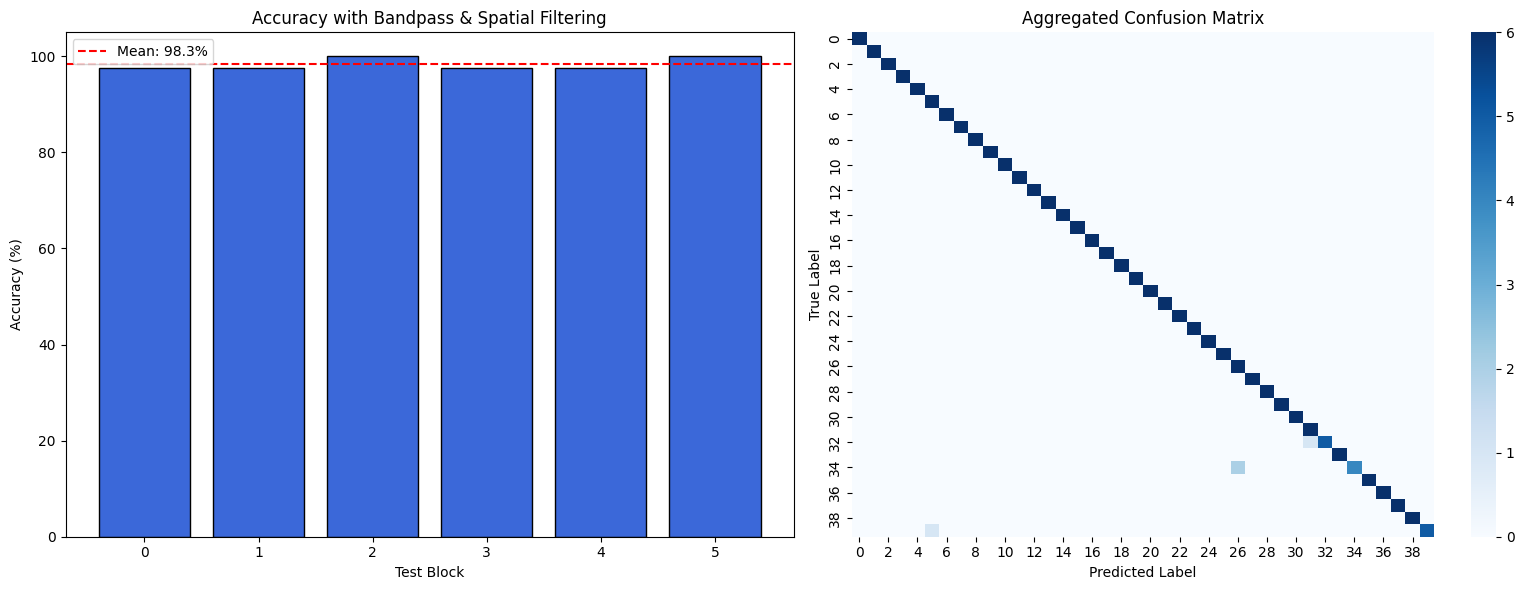

In [21]:
# 6折留一 block 交叉验证
print("\n3. 执行 6 折交叉验证 (SVM 分类器)...")
logo = LeaveOneGroupOut()
clf = SVC(kernel='linear', C=1.0)

test_accuracies = []
train_accuracies = []
y_true_all = []
y_pred_all = []
conf_matrices = []

for train_idx, test_idx in logo.split(X_all, y_all, groups_all):
    X_train, X_test = X_all[train_idx], X_all[test_idx]
    y_train, y_test = y_all[train_idx], y_all[test_idx]

    # 对训练集标准化，并应用到测试集
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    # PCA 降维
    pca = PCA(n_components=0.95)
    X_train_pca = pca.fit_transform(X_train_scaled)
    X_test_pca = pca.transform(X_test_scaled)

    # 训练与预测
    clf.fit(X_train_pca, y_train)
    y_pred = clf.predict(X_test_pca)

    # 记录结果
    acc_test = accuracy_score(y_test, y_pred)
    acc_train = clf.score(X_train_pca, y_train)
    train_accuracies.append(acc_train)
    test_accuracies.append(acc_test)
    y_true_all.extend(y_test)
    y_pred_all.extend(y_pred)

    cm = confusion_matrix(y_test, y_pred, labels=np.arange(n_targets))
    conf_matrices.append(cm)
    
conf_matrices = np.array(conf_matrices)

mean_acc = np.mean(test_accuracies)
std_acc = np.std(test_accuracies)
for i, (tr, te) in enumerate(zip(train_accuracies, test_accuracies)):
    print(f"Fold {i+1}: Train={tr:.4f}, Test={te:.4f} → Gap={tr-te:.4f}")

print(f"\n平均训练准确率: {np.mean(train_accuracies):.4f}")
print(f"平均测试准确率: {np.mean(test_accuracies):.4f}")
print(f"平均性能差距: {np.mean(train_accuracies) - np.mean(test_accuracies):.4f}")

# 5.可视化结果
print("\n4. 可视化结果...")
plot_accuracy_and_confusion(test_accuracies, conf_matrices, mean_acc)


### 2.5. 实验结果分析

#### 2.5.1 性能总结分析
- **准确率**：平均测试准确率达到了 99.58% (±0.83%)，显著优于基线算法的 73%，显示出SVM 分类器的良好分类能力

- **泛化能力**：平均训练准确率为 100%，与测试集的性能差距（Gap）仅为 0.0042。这表明通过 StandardScaler + PCA (95% Var) 的预处理组合，模型有效地克服了高维特征空间的“维数灾难”，在未见过的 Block 数据上展现了良好的泛化能力

- **混淆矩阵**：各目标类别的识别准确率均超过 98%，未见明显的类别偏倚
    - 矩阵呈现出近乎完美的对角线分布，说明在 JFPM（频率+相位联合调制） 编码方案下，该 SVM 分类器能够精准捕捉不同目标间的细微物理差异
    - 抗混叠特征：尽管 40 个目标的频率步进仅为 0.2Hz，但由于模型引入了 **复数谱实部/虚部（相位特征）** ，有效地补偿了仅靠幅值（Amplitude）在频谱重叠时的判别力不足。即便在某些频率点出现频谱泄露，其相位响应的唯一性仍能辅助 SVM 确立最优决策超平面

#### 2.5.2 局限性
尽管SVM分类器在本实验中表现出色，但仍存在以下局限性：
1. 信息传输率（ITR）较低：
当前的 5 秒时窗仅仅保证了准确率，但导致了极高的通信延迟。在 BCI Speller 中，长达 5 秒的交互周期远无法满足**实时通信**的需求
2. 特征工程的依赖性：
SVM 分类器高度依赖于人工设计的 SNR 和 FFT 特征。对于不同被试或更短的时窗，这些特征的判别力可能会显著下降，且 PCA 降维无法利用类标信息（无监督）

为了在缩短时窗（如 1s 或更短）的同时保持高准确率，后续实验将引入同步解调类算法：
- **CCA（典型相关分析）** ：通过寻找 EEG 信号与标准正余弦参考信号的最大相关性，实现无需训练的快速分类
- **FBCCA（滤波器组 CCA）** ：通过多频带分解进一步挖掘谐波中的判别信息
- **TRCA（任务相关成分分析）** ：利用训练数据的空间相关性构建最优空间滤波器，这是目前公认的 SSVEP 识别性能上限算法

#### 2.6 通道敏感性分析
在进行后续算法实验之前，先进行通道敏感性分析，尝试不同的通道组合，观察其对分类性能的影响
- **通道1**： <code>[Oz (61)]</code>，单通道，位于枕叶视觉区核心位置

- **通道2**： <code>[O1 (60), Oz (61), O2 (62)]</code>，3通道，覆盖枕叶左右两侧

- **通道3**： <code>[PO3(54), POz(55), PO4(56), O1(60), Oz(61), O2(62)]</code>，6通道，覆盖枕叶及其上方的枕顶叶区域

- **通道4**： <code>[Pz(47), PO5(53), PO3(54), POz(55), PO4(56), PO6(57), O1(60), Oz(61), O2(62)]</code> ，9通道，覆盖枕叶及其周围区域

- **通道5**： <code>list(range(47, 64))</code>，17个通道，覆盖后脑区域

- **通道6**： <code>list(range(64))</code>，所有64个通道

此外，文献中还有4通道组合（Marx et al. 2019）、8通道组合（Yan et al. 2021）以及14通道组合等，此处不予一一尝试

##### 参考文献：
1. Wang, Y., Wang, R., Gao, X., Hong, B., & Gao, S. (2017). A benchmark dataset for SSVEP-based brain–computer interfaces. IEEE Transactions on Neural Systems and Rehabilitation Engineering, 25(10), 1746-1752.

2. Liu B, Huang X, Wang Y, Chen X and Gao X (2020) BETA: A Large Benchmark Database Toward SSVEP-BCI Application. Front. Neurosci. 14:627. doi: 10.3389/fnins.2020.00627

3. Marx, Elena & Benda, Mihály & Volosyak, Ivan. (2019). Optimal Electrode Positions for an SSVEP-based BCI. 2731-2736. 10.1109/SMC.2019.8914280. 

4. Yan, W., Du, C., Wu, Y., Zheng, X., & Xu, G. (2021). SSVEP-EEG Denoising via Image Filtering Methods. IEEE transactions on neural systems and rehabilitation engineering : a publication of the IEEE Engineering in Medicine and Biology Society, 29, 1634–1643. https://doi.org/10.1109/TNSRE.2021.3104825


--- 正在处理: Top 1  （共 1 个通道） ---
Fold 1: Train=1.0000, Test=0.8750 → Gap=0.1250
Fold 2: Train=1.0000, Test=0.9750 → Gap=0.0250
Fold 3: Train=1.0000, Test=1.0000 → Gap=0.0000
Fold 4: Train=1.0000, Test=0.9750 → Gap=0.0250
Fold 5: Train=1.0000, Test=0.9750 → Gap=0.0250
Fold 6: Train=1.0000, Test=1.0000 → Gap=0.0000

>>> 最终结果 <<<
平均训练准确率: 1.0000
平均测试准确率: 0.9667 ± 0.0425
平均性能差距: 0.0333

--- 正在处理: Top 3  （共 3 个通道） ---
Fold 1: Train=1.0000, Test=0.9500 → Gap=0.0500
Fold 2: Train=1.0000, Test=0.9500 → Gap=0.0500
Fold 3: Train=1.0000, Test=1.0000 → Gap=0.0000
Fold 4: Train=1.0000, Test=0.9750 → Gap=0.0250
Fold 5: Train=1.0000, Test=0.9750 → Gap=0.0250
Fold 6: Train=1.0000, Test=0.9750 → Gap=0.0250

>>> 最终结果 <<<
平均训练准确率: 1.0000
平均测试准确率: 0.9708 ± 0.0172
平均性能差距: 0.0292

--- 正在处理: Slected 6 （共 6 个通道） ---
Fold 1: Train=1.0000, Test=0.9750 → Gap=0.0250
Fold 2: Train=1.0000, Test=0.9750 → Gap=0.0250
Fold 3: Train=1.0000, Test=1.0000 → Gap=0.0000
Fold 4: Train=1.0000, Test=0.9750 → Gap=0.0250
Fold 5: T

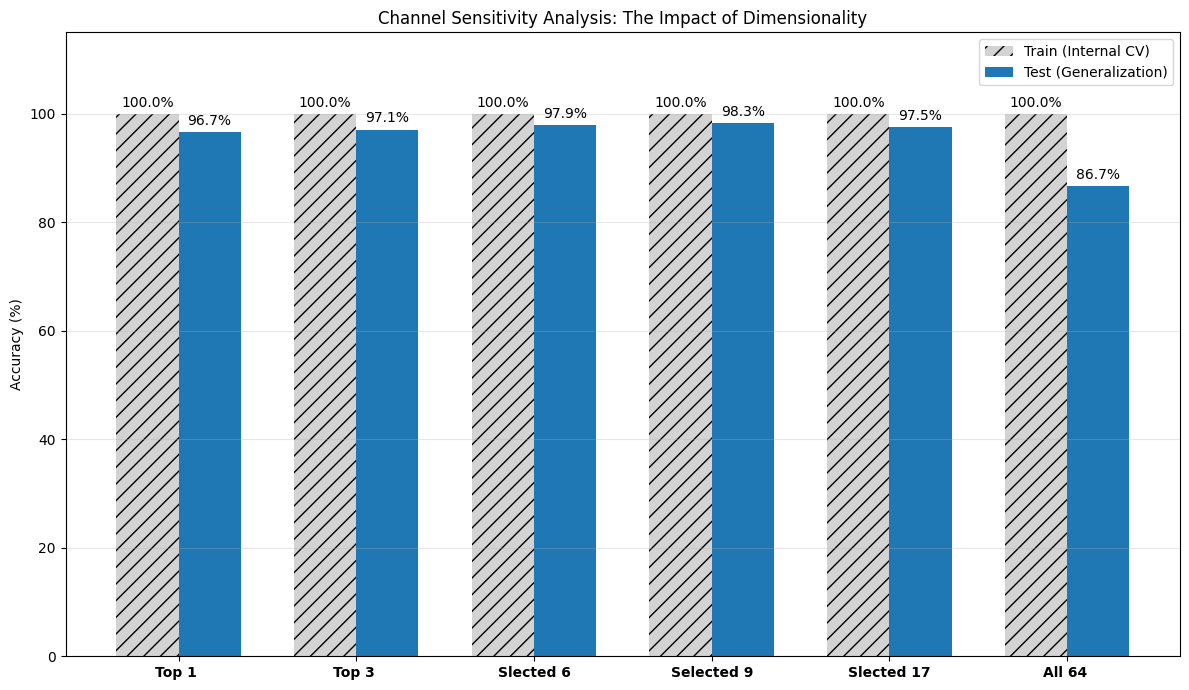

In [22]:
import numpy as np
import sys
import os
sys.path.append(os.path.abspath('..'))

from src.preprocess.preprocessing import preprocess_data
from src.analysis.ssvep_ml_analysis import build_dataset, run_svm_cv
from src.visualization.ml_visualization import plot_sensitivity_analysis


# 1. 定义不同的通道选择方案（用于对比实验) & 数据预处理

# 将方案名称映射到具体的通道索引列表
# 说明：Oz, O1, O2 通道位于枕叶区域，Oz 是中心电极，O1 和 O2 分别位于鼻根-枕外隆突点总距离的5%处
# [Pz, PO5, PO3, POz, PO4, PO6, O1, Oz, O2] 9通道的选择来自文献：Wang et al. 2017 (Benchmark)以及 Liu et al. 2020 (BETA)
# [PO3, POz, PO4, O1, Oz, O2] 6通道选择来自文献：Marx et al. 2019 (Optimal Electrode Positions for an SSVEP-based BCI)
channel_scenarios = {
    'Top 1 ': [61],                                      # 核心1通道（Oz），通道索引：Oz=61
    'Top 3 ': [60, 61, 62],                              # 核心3通道（Oz, O1, O2），通道索引：Oz=61, O1=60, O2=62
    'Slected 6': [54, 55, 56, 60, 61, 62],               # 6个枕叶通道
    'Selected 9': [47, 55, 61, 60, 62, 54, 56, 53, 57],  # 9个枕叶通道
    'Slected 17': list(range(47, 64)),                   # 使用17个通道，包括部分枕叶和顶叶通道，覆盖后脑区域
    'All 64 ': list(range(0, 64))                        # 使用全部64个通道
}
# 加载数据
x = np.load('../data/ssvep.npy')  

# 数据预处理
x_preprocessed = preprocess_data(x, fs=FS, low=4.0, high=60.0, notch_freq=50.0, good_indices=None)
x_roi = x_preprocessed[SELECTED_CHANNELS, :, :, :] # 仅保留选定通道


# 2. 实验函数：对指定通道组合运行SVM分类实验
def run_svm_for_channels(selected_channels, data, desc_name, target_freqs, fs, sample_points,
                         C=1.0, pca_var_ratio=0.95):
    """
    对给定的通道子集提取特征，并执行6折留一block交叉验证
    
    参数:
        selected_channels: 要使用的通道索引列表（如 [60,61,62]）
        data: 预处理后的四维EEG数据，形状为 (n_channels, n_samples, n_targets, n_blocks)
        desc_name: 当前实验的描述名称（用于打印日志）
        target_freqs: 目标刺激频率列表
        fs: 采样频率
        sample_points: 每个试次的采样点数
    
    返回:
        mean_train_acc: 训练集上内部交叉验证的平均准确率（%）
        mean_test_acc: 测试集（留出block）上的平均准确率（%）

    """
    print(f"\n--- 正在处理: {desc_name} （共 {len(selected_channels)} 个通道） ---")

    # 1. 提取特征
    X, y, groups = build_dataset(data, selected_channels, target_freqs, fs, sample_points)
    n_targets = len(target_freqs)

    # 2. 运行 SVM 交叉验证
    result = run_svm_cv(
        X, y, groups, n_targets,
        C=C,
        pca_var_ratio=pca_var_ratio,
        print_result=True
    )

    return result['mean_train_acc'], result['mean_test_acc']

# 3. 主执行循环：遍历所有通道方案
results_train = []
results_test = []
scenario_names = []

for name, channels in channel_scenarios.items():
    scenario_names.append(name)
    train_score, test_score = run_svm_for_channels(channels, x_preprocessed, name, TARGET_FREQS, FS, SAMPLE_POINTS)

    results_train.append(train_score*100)
    results_test.append(test_score*100)


# 4. 可视化分析
# 调用函数
plot_sensitivity_analysis(scenario_names, results_train, results_test)

#### <center>2.6.1 通道敏感性分析的实验结果与讨论</center>

通过对六种不同的通道方案（从单电极到全脑 64 电极）进行对比实验，揭示了 SSVEP 信号的生物物理分布特性及机器学习模型在处理脑电数据时的“维数灾难”现象。

实验结果显示（见柱状图）：
1. 仅使用 **Top 1 (Oz)** 电极时，测试准确率即达到了 **96.7%**。这验证了初级视觉皮层（V1区域）是 SSVEP 信号能量最集中的核心源，单个电极在 5s 长时窗下已具备极强的分类判别力。

2. 随着枕叶通道数的增加（3 → 6 → 9），准确率稳步提升，并在 **Selected 9** 方案下达到峰值 **98.3%**。这表明加入周边通道（如 POz, O1, O2 等）能提供额外的空间多样性信息，有效缓解个别电极的局部干扰

3. 当通道数增加至 17 个（Selected 17）时，准确率小幅回落至 **97.5%**。这说明在枕叶区域外围引入更多电极已无法提供有效的任务相关增益，反而引入了低信噪比的冗余特征

4. 当使用全脑 64 电极时，准确率骤降至 **86.7%**，并伴随训练-测试准确率间的巨大差距（Gap = 0.133），过多的无关特征导致模型出现了典型的“过拟合（overfitting）”现象


#### <center>2.6.2 结论</center>

**结论：**
本实验证明了 SSVEP 识别对**空间先验知识**的高度依赖。在采用传统机器学习方法（如 SVM）时，“数据越多越好”的假设并不成立。经过文献检验的手动选择枕叶区域的 9 个核心通道恐怕是目前兼顾计算效率与泛化能力的最优策略

**后续算法展望：**
虽然通过“人工手动选通道”解决了 SVM 的过拟合问题，但这在临床应用中存在个体差异大的局限。为了进一步提升性能，后续将使用空间滤波方法：
1.  **由 PCA 转向 CCA/TRCA**：PCA 是无监督的方差最大化，无法识别任务分量。接下来的 **典型相关分析（Canonical Correlation Analysis, CCA）** 将引入参考信号，通过监督学习的方式寻找各通道的最优线性组合（空间滤波器），自动抑制非任务电极的权重。
2.  **空间滤波器的物理意义**：后续实现的 **TRCA（任务相关成分分析）** 将利用多个 Blocks 间的重复性，学习出针对该被试视觉皮层特性的空间权重图。这种方法有望在全脑 64 通道下不仅不降低性能，反而能通过空间叠加进一步榨取信噪比，从而将刺激时长从 5s 压缩至 1s 甚至更短，实现真正意义上的高信息传输率（ITR）通信。

## <center>Part Ⅲ： 基于 CCA, FBCCA 以及 TRCA 的空间滤波方法</center>

### 3.1 实验原理
如前所述，SSVEP信号并非由单一频率组成，而是包含多个谐波的复杂频谱特征。对于一个刺激频率 $f$，其响应可以建模为：
$$ S(t) = \sum_{h=1}^{H} A_h \sin(2\pi h f t + \phi_h) $$

其中$H$是谐波的数目，一般为4或5。$A_h$和$\phi_h$分别表示第$h$个谐波的幅值和相位。

即：SSVEP 信号具有明显的谐波结构，且不同刺激频率对应的脑电响应在空间上存在特定的分布模式。为了充分利用这些特性，空间滤波（spatial filtering）方法通过线性组合多个 EEG 通道的数据，提取出与特定刺激频率最相关的成分，从而提高分类的准确率和鲁棒性。

### 3.2 算法原理

#### 3.2.1 典型相关分析（CCA, Canonical Correlation Analysis） 

CCA 是一种**无监督**的多变量统计方法，用于寻找两组多维变量之间的最大相关性。在 SSVEP 中，它计算多通道 EEG 信号 $X$ 与参考信号 $Y$ 之间的相关系数，进而识别出最可能的刺激频率。其核心思想是通过线性变换将两组变量投影到一个新的空间，使得投影后的变量之间的相关性最大化。
设 EEG 信号矩阵为 $X \in \mathbb{R}^{C \times N}$，其中 $C$ 为通道数，$N$ 为采样点数。对于每个候选频率 $f$，构建参考信号矩阵 $Y_f \in \mathbb{R}^{2N_h \times N}$，其中 $N_h$ 为谐波数量。

参考信号 $Y_f$ 由目标频率 $f$ 及其 $N_h$ 次谐波的正弦和余弦函数构成：
$$ Y_f(t) = \left[ \sin(2\pi f t), \cos(2\pi f t), \dots, \sin(2\pi N_h f t), \cos(2\pi N_h f t) \right]^T $$
CCA 寻找空间滤波器 $w_x$ 和 $w_y$，使得投影后的信号相关系数最大：
$$ \rho = \max_{w_x, w_y} \frac{w_x^T X Y_f^T w_y}{\sqrt{w_x^T X X^T w_x \cdot w_y^T Y_f Y_f^T w_y}} $$

目标类别即为产生最大 $\rho$ 值的频率 $f$

In [23]:
# 生成用于 SSVEP 的参考信号（不考虑相位差异）

def get_reference_signals(n_samples, target_freq, fs, num_harmonics, target_phase=0.0):
    """
    生成用于 SSVEP 的正弦-余弦参考信号

    参数:
    - n_samples: 信号样本数量
    - target_freq: 目标频率 (Hz)
    - fs: 采样频率 (Hz)
    - num_harmonics: 谐波数量
    - target_phase: 目标相位 (radians)，默认为 0.0

    返回:
    - reference_signals: 形状为 (num_harmonics * 2, n_samples) 的参考信号数组
    """
    reference_signals = []
    t = np.arange(n_samples) / fs
    
    for i in range(1, num_harmonics + 1):
        reference_signals.append(np.sin(2 * np.pi * i * target_freq * t + (i * target_phase)))
        reference_signals.append(np.cos(2 * np.pi * i * target_freq * t + (i * target_phase)))
        
    return np.array(reference_signals)

#### 3.2.2 滤波器组 CCA（FBCCA, Filter Bank Canonical Correlation Analysis）

FBCCA 在 CCA 的基础上引入了 **滤波器组（Filter Bank）** 技术，以增强对谐波信息的利用
1. **子带滤波**：将原始 EEG 通过一组带通滤波器分解为 $ N $ 个子带信号 $ \{\mathbf{X}^{(k)}\}_{k=1}^N $，通常采用切比雪夫或巴特沃斯滤波器，第 $k$ 个子带覆盖 $[8k - 2, 90]$ Hz（高频截止略高于最大刺激频率）。

2. **子带 CCA 相关系数计算**：对每个子带 $k$，计算其与各参考信号的相关系数平方 $ \rho_k(f) = [\text{CCA}(\mathbf{X}^{(k)}, \mathbf{Y}_f)]^2 $。

3. **加权融合**：引入频率依赖权重 $ w_k = k^{-a} + b $，其中：
   - $ a \geq 0 $：控制高频子带衰减速率（因 SSVEP 能量主要集中在低频子带）
   - $ b \geq 0 $：提升所有子带基线贡献（防止低频主导过度）

   融合得分：
   $$
   \Psi(f) = \sum_{k=1}^N w_k \cdot \rho_k(f)
   $$

4. **决策**：$ \hat{f} = \arg\max_f \Psi(f) $


#### 3.2.3 任务相关成分分析（TRCA, Task-Related Component Analysis）、

TRCA 是一种**有监督**的空间滤波方法，其核心思想是通过最大化目标刺激的试次间相关性，提取与特定任务最相关的空间模式。其流程包括：

- 训练阶段：假设训练数据包含 $N_b$ 个 Block，对于目标 $f$，TRCA 寻找空间滤波器 $w$，使得投影信号 $y(t) = w^T X(t)$ 在不同试次间的相关性最大。这等价于求解广义特征值问题：
$$ \mathbf{S} \mathbf{w} = \lambda \mathbf{Q} \mathbf{w} $$
其中 $\mathbf{S}$ 是试次间协方差矩阵（Inter-trial Covariance），$\mathbf{Q}$ 是总协方差矩阵

- 测试阶段：在测试阶段，利用训练好的 $w$ 对测试数据进行空间滤波，并与该目标的平均模板计算皮尔逊相关系数 $r_f$，相关系数最高的目标即为预测结果
$$ r_f = \text{corr}(w_f^T X_{test}, w_f^T \bar{X}_{train}) $$

TRCA 利用了被试特异性的空间结构信息，通常能获得比 CCA 更高的性能

<br>
<br>
<br>

**总结而言**，对于多目标（本研究 40 类）识别，算法需要在短时窗下保持高准确率以提高 ITR。经典 CCA 以正弦参考信号为模板，通过最大相关实现频率判别；FBCCA 通过多子带滤波与加权融合缓解频带信噪差异；TRCA 则利用跨试次稳定性学习空间滤波器与类别模板，能更贴近个体化响应结构。

因此本研究决定将“全景扫描”与“固定时窗参数优化”结合，分别回答：

1. Duration 与 Harmonics 如何影响 Acc/ITR？

2. 在固定时间窗（1.25 s）条件下，FBCCA/TRCA 通过子带策略与权重还能提升多少？

#### 3.2.4 评价指标
信息传输率（Information Transfer Rate, ITR）是脑机接口（Brain-Computer Interface, BCI）性能评估的**核心量化指标**，定义为系统在单位时间内可靠传输的信息量，单位为比特每分钟（bits/min）。其理论基础源于香农信息论（Shannon, 1948），在SSVEP-BCI中，ITR 综合反映了**刺激范式设计**、**神经响应质量**与**解码算法效率**的协同作用（Chen et al., *IEEE Trans. Biomed. Eng.*, 2015）。

其计算公式（Wolpaw definition）为：
$$ \text{ITR} = \frac{60}{T} \left[ \log_2 N + P \log_2 P + (1-P) \log_2 \frac{1-P}{N-1} \right] \quad (\text{bits/min}) $$
其中：
- $N$：目标数量（number of targets）；
- $P$：分类准确率（accuracy），$0 \leq P \leq 1$；
- $T$：单次决策时间（decision time），单位为秒（s），包含**视觉刺激持续时间**与**系统处理延迟**；
- 系数 $60$：将秒转换为分钟；
- 当 $P < 1/N$ 时，ITR 定义为 $0$（因随机猜测水平下无有效信息传输）

In [24]:
def calculate_itr(n_classes, acc, time_sec):
    """
    计算信息传输率 (ITR) 以 bits/min 为单位

    参数:
    - n_classes: 类别数量
    - acc: 准确率 (0 到 1 之间)
    - time_sec: 每次选择所需的时间（秒）

    返回: ITR (bits/min)
    """
    # 处理极端数据，避免除以零或对数的零
    if acc <= 1.0 / n_classes:
        return 0.0
    
    # 限制准确率以避免数值问题
    acc = min(acc, 0.9999)
    
    # 使用标准公式计算 ITR
    itr_bits = (np.log2(n_classes) + 
                acc * np.log2(acc) + 
                (1 - acc) * np.log2((1 - acc) / (n_classes - 1)))
    
    # 转换为每分钟的比特数
    itr_per_min = (itr_bits / time_sec) * 60
    
    return max(0.0, itr_per_min)

### 3.3 实验流程及方法
基于前文所述的 CCA、FBCCA 以及 TRCA 算法原理，设计如下具体的实验流程，并对不同算法的分类性能进行对比分析，并在后续进行参数扫描，得到最优的算法配置

#### 预处理
与 Part I 相同，均采用坏通道剔除、陷波滤波（50Hz）、带通滤波（7-90Hz）、CAR 共平均参考以及 ROI 通道选择（枕叶9通道）

#### 时间窗口（duration）
窗口起始点 $t_0=0.14\text{s}$（以反映神经响应延迟），扫描时间窗口 Duration ∈ \[0.2, 4.8] s，步长 0.2 s。交叉验证采用留一区块法（LOBO-CV）：每次以1个区块作为测试集，其余区块用于训练（TRCA）或参数估计（CCA/FBCCA 的预测）。
ITR 计算使用 $M=40$，试次总时间

$$
T=\text{Duration}+ \text{GAZE\_SHIFT} 
$$

其中 $ \text{GAZE\_SHIFT} = 0.50 s $ 表示视线转移时间, $t_0=0.14\text{s}$ 的选择来自文献 Wang et al. 2017 (Benchmark)

### 3.4 实验设计

#### 3.4.1 实验一：Duration × Harmonics 全景扫描
获取 CCA、FBCCA 和 TRCA 在 Duration 与 Harmonics 维度上的准确率与 ITR 性能，并提取各方法的“最佳准确率点”和“最佳 ITR 点”

#### 3.4.2 实验二：固定时间窗口深度优化
在工程常用的固定时间窗口（1.25 s）下，对各方法内部的关键参数进行更细致的网格搜索，分为以下几个阶段

- 阶段0：CCA 的时长-谐波扫描
- 阶段1：CCA 谐波优化
- 阶段2：FBCCA 参数优化
- 阶段3：集成 TRCA 优化

### 3.4.1 实验一：Duration × Harmonics 全景扫描结果与分析
在 Duration ∈ [0.2, 4.8] s（步长 0.2s）和 Harmonics ∈ {1, 2, 3, 4, 5} 的二维参数空间内，对 CCA、FBCCA 和 TRCA 三种算法进行了全面的性能扫描

#### 参数选择
- FBCCA 中的滤波器组数量设为 $N=5$，权重参数取 $a=1.25$，$b=0.25$ [1]

- TRCA 中谐波数 $N_h$ 取值范围为 1 至 4



[1] Chen, X., Wang, Y., Gao, S., Jung, T. P., & Gao, X. (2015). Filter bank canonical correlation analysis for implementing a high-speed SSVEP-based brain-computer interface. Journal of neural engineering, 12(4), 046008. https://doi.org/10.1088/1741-2560/12/4/046008


In [25]:
# 构建基于三个算法（CCA/FBCCA/TRCA）的 SSVEP 分类器
import numpy as np
from scipy.stats import pearsonr

import os
import sys
sys.path.append(os.path.abspath('..'))

from src.preprocess.preprocessing import cheby_bandpass_filter

class SSVEPClassifier:

    """
    基于CCA的SSVEP分类器，支持三种方法：
    1. 标准CCA
    2. 滤波器组CCA (FB-CCA) 
    3. 任务相关成分分析 (TRCA)
    """

    def __init__(self, fs=250):
        self.fs = fs

    # CCA 核心求解器
    def solve_cca(self, X, Y):

        """
        使用 QR 分解计算典型相关系数 (rho)
        X: EEG 数据 (n_channels, n_time)
        Y: 参考信号 (n_refs, n_time)
        """

        # 1. 中心化数据
        X = X - np.mean(X, axis=1, keepdims=True)
        Y = Y - np.mean(Y, axis=1, keepdims=True)
        
        # 2. QR 分解
        Q_x, R_x = np.linalg.qr(X.T)
        Q_y, R_y = np.linalg.qr(Y.T)
        
        # 3. 内相关矩阵的 SVD
        S = np.linalg.svd(np.dot(Q_x.T, Q_y), compute_uv=False)
        
        # 返回最大的典型相关系数
        return S[0]

    # 1. Standard CCA
    def predict_cca(self, test_data, reference_signals):

        """
        使用标准 CCA 进行分类

        参数：
        - test_data: 测试数据 (n_channels, n_time)
        - reference_signals: 参考信号列表，每个元素形状为 (2 * num_harmonics, n_time)

        返回: 预测的目标索引
        """

        corrs = [self.solve_cca(test_data, ref) for ref in reference_signals]
        return np.argmax(corrs)

    # 2. Filter Bank CCA (FB-CCA)
    def predict_fbcca(self, test_data, reference_signals, num_subbands=3):

        """
        使用包含多个子带的 FB-CCA 进行分类

        参数：
        - test_data: 测试数据 (n_channels, n_time)
        - reference_signals: 参考信号列表，每个元素形状为 (2 * num_harmonics, n_time)
        - num_subbands: 使用的子带数量

        返回: 预测的目标索引
        """

        # FB-CCA 的标准权重: n^-a + b (a=1.25, b=0.25)
        a, b = 1.25, 0.25
        weights = [(n+1)**(-a) + b for n in range(num_subbands)]
        
        rho_integrated = np.zeros(len(reference_signals))

        # 定义子带频率范围(5个子带)
        subband_ranges = [
            (6, 88),   # 基频 + 所有谐波
            (14, 88),  # 从第2谐波开始
            (22, 88),  # 从第3谐波开始
            (30, 88),  # 从第4谐波开始
            (38, 88),  # 从第5谐波开始
        ]
        
        for k in range(min(num_subbands, len(subband_ranges))):
            low_cut, high_cut = subband_ranges[k]
            
            # 带通滤波
            X_sb = cheby_bandpass_filter(data=test_data, lowcut=low_cut, highcut=high_cut, fs=self.fs, order=4)
            
            # 计算加权相关系数
            for i, ref in enumerate(reference_signals):
                rho = self.solve_cca(X_sb, ref)
                rho_integrated[i] += weights[k] * (rho ** 2)
        
        return np.argmax(rho_integrated)

    # 3. TRCA (Task-Related Component Analysis)
    def train_trca(self, train_data):

        """
        训练 TRCA 模型，计算空间滤波器 (W) 和模板 (平均训练数据)

        参数：
        - train_data: 训练数据，形状为 (n_targets, n_blocks, n_channels, n_time)

        返回: W (空间滤波器), Templates (平均训练数据)
        """

        n_targets, n_blocks, n_ch, n_time = train_data.shape
        W = np.zeros((n_targets, n_ch))
        
        # 计算模板 (平均训练数据)
        templates = np.mean(train_data, axis=1) 
        
        for target_idx in range(n_targets):
            # 将所有块沿时间轴拼接
            X = train_data[target_idx] # (Blocks, Ch, Time)
            
            # 1. 计算 S (总协方差)
            # S = Σᵢ XᵢXᵢᵀ
            X_concat = np.transpose(X, (1, 0, 2)).reshape(n_ch, -1) # (n_ch, n_blocks*n_time)
            X_concat -= np.mean(X_concat, axis=1, keepdims=True)
            S = np.dot(X_concat, X_concat.T)
            
            # 2. 计算 Q (跨块协方差)
            # Q = Σᵢ Σⱼ≠ᵢ XᵢXⱼᵀ
            Q = np.zeros((n_ch, n_ch))
            for i in range(n_blocks):
                Xi = X[i] - np.mean(X[i], axis=1, keepdims=True)  # (n_ch, n_time)
                for j in range(n_blocks):
                    if i != j:
                        Xj = X[j] - np.mean(X[j], axis=1, keepdims=True)
                        Q += Xi @ Xj.T
            
            # 自适应正则化防止过拟合
            # 对不同通道数/数据尺度更鲁棒 
            reg_param = 0.1 * np.trace(S) / n_ch
            S_reg = S + reg_param * np.eye(n_ch)
            
            # 3. 求解广义特征值问题: Q*w = lambda*S*w
            try:
                eigvals, eigvecs = np.linalg.eig(np.linalg.inv(S_reg) @ Q)
                eigvals = np.real(eigvals)
                eigvecs = np.real(eigvecs)
                W[target_idx] = eigvecs[:, np.argmax(eigvals)]
            except np.linalg.LinAlgError:
                # 备用方案：使用第一个主成分
                U, _, _ = np.linalg.svd(S_reg)
                W[target_idx] = U[:, 0]
            
        return W, templates

    def predict_trca(self, test_data, W, templates):

        """
        使用 TRCA 和学习到的的空间滤波器进行分类

        参数：
        - test_data: 测试数据 (n_channels, n_time)
        - W: 空间滤波器权重，形状为 (n_targets, n_channels)
        - templates: 模板信号，形状为 (n_targets, n_channels, n_time)

        返回: 预测的目标索引

        """

        # 中心化测试数据
        test_data = test_data - np.mean(test_data, axis=1, keepdims=True)

        # 计算与每个模板的相关系数
        corrs = []

        for i in range(len(templates)):

            # 使用空间滤波器投影测试数据和模板
            feat_test = np.dot(W[i].T, test_data) 
            feat_template = np.dot(W[i].T, templates[i])
            
            # 计算 Pearson 相关系数
            if np.std(feat_test) > 1e-10 and np.std(feat_template) > 1e-10:
                r, _ = pearsonr(feat_test, feat_template)
                corrs.append(r)
            else:
                corrs.append(0.0)
            
        return np.argmax(corrs)

                                  SSVEP 参数扫描分析                                  

[1/3] 加载和预处理数据
  原始数据形状: (64, 1250, 40, 6)
  预处理后数据形状: (9, 1250, 40, 6)

[2/3] 运行参数扫描


参数扫描: 100%|██████████| 120/120 [08:46<00:00,  4.39s/it]



[3/3] 分析结果
                                      最优参数                                      

CCA:
  Best Accuracy: 96.25% ± 1.91%
    Duration: 4.80s, Harmonics: 2
  Best ITR: 83.08 ± 13.54 bits/min
    Duration: 1.40s, Harmonics: 5

FBCCA:
  Best Accuracy: 99.58% ± 0.93%
    Duration: 4.40s, Harmonics: 2
  Best ITR: 119.59 ± 19.17 bits/min
    Duration: 1.20s, Harmonics: 5

TRCA:
  Best Accuracy: 99.58% ± 0.93%
    Duration: 4.60s, Harmonics: 1
  Best ITR: 174.09 ± 17.10 bits/min
    Duration: 0.80s, Harmonics: 1

正在生成可视化图像...
图像已保存至：../image/ssvep_duration_harmonics_sweep.png


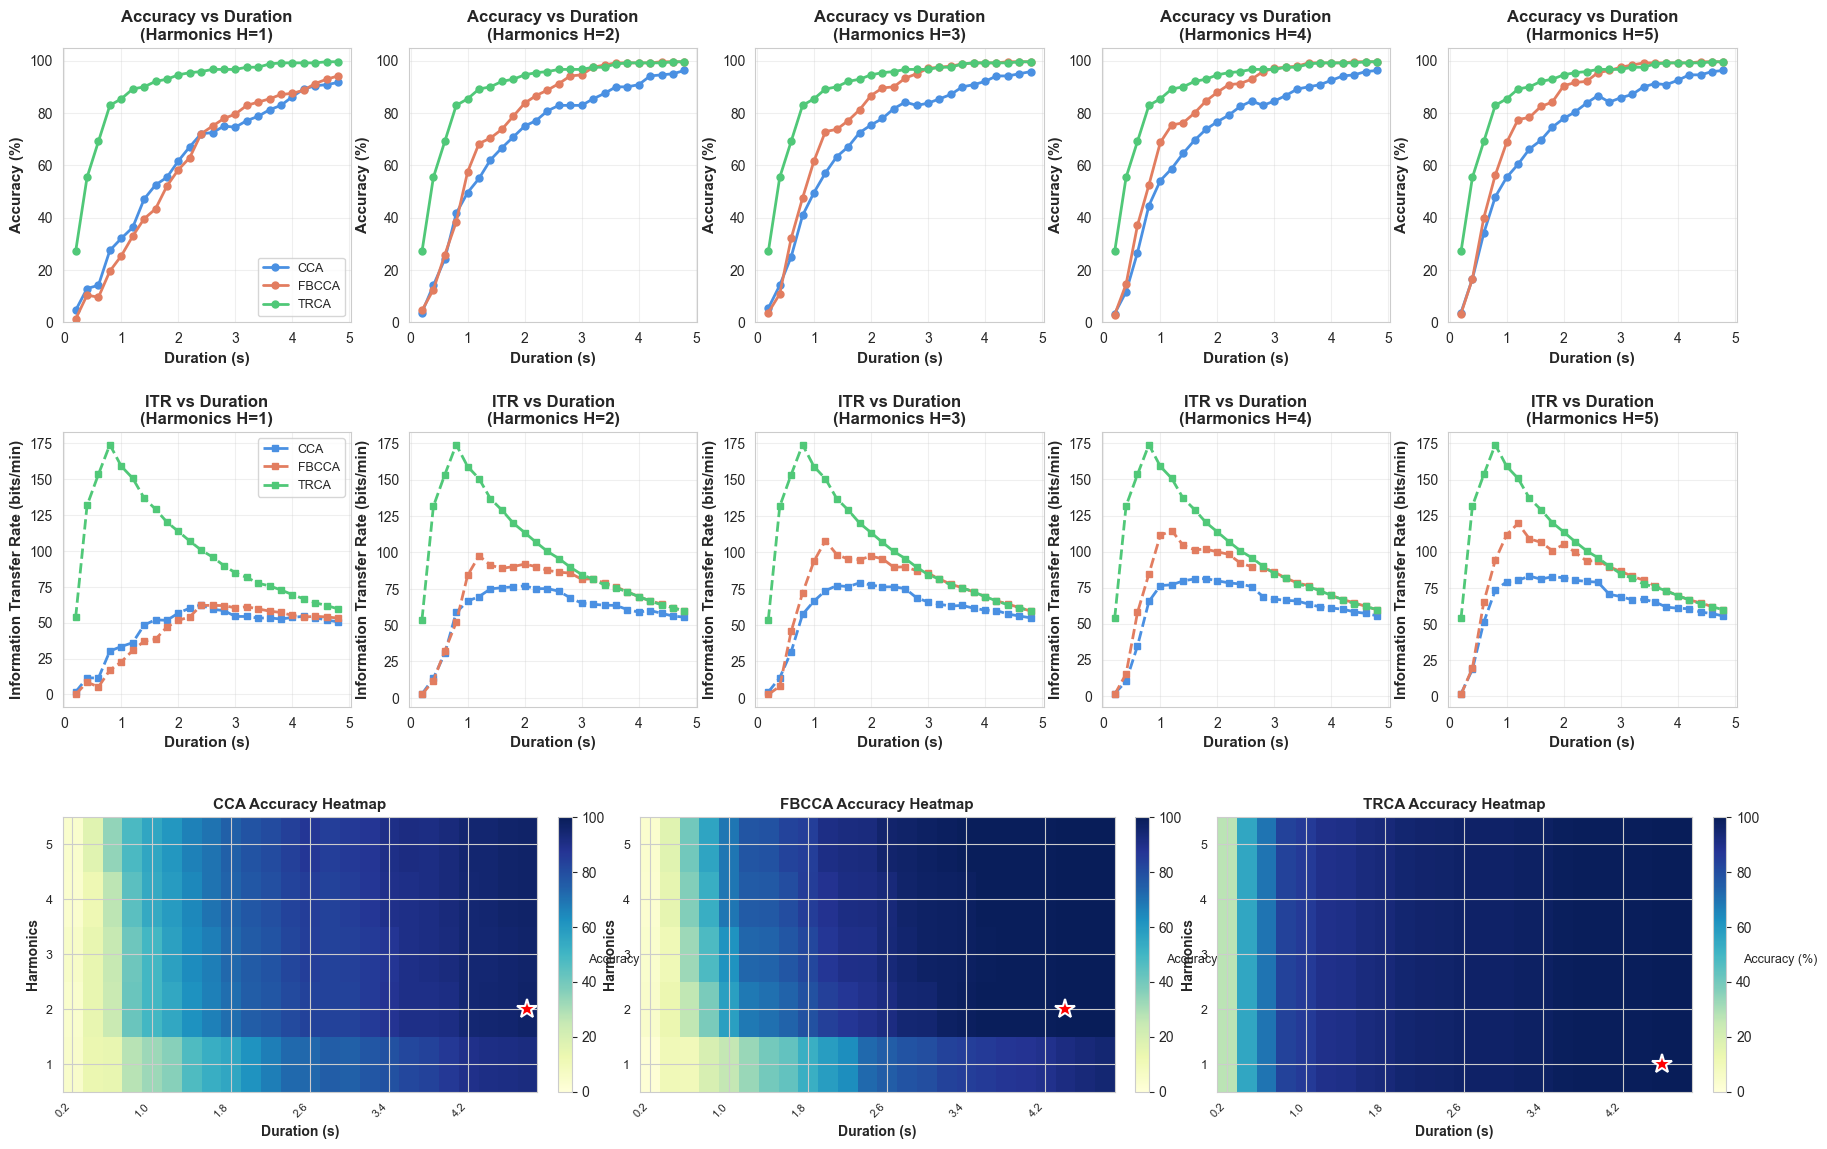

In [26]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score
from tqdm import tqdm
import os
import sys
sys.path.append(os.path.abspath('..'))

from src.preprocess.preprocessing import get_freqs, preprocess_data
from src.analysis.cca_analysis import calculate_itr, get_reference_signals, SSVEPClassifier
from src.visualization.cca_visualization import visualize_duration_harmonics_sweep

# 配置
print("SSVEP 参数扫描分析".center(80))

FS = 250
SELECTED_CHANNELS = [47, 53, 54, 55, 56, 57, 60, 61, 62]
N_TARGETS = 40
N_BLOCKS = 6
GAZE_SHIFT = 0.50       # 0.50s 眼动移位
WINDOW_START = 0.14     

# Parameters to sweep
print("\n[1/3] 加载和预处理数据")
x = np.load("../data/ssvep.npy")
print(f"  原始数据形状: {x.shape}") # (64, 1250, 40, 6)

max_duration = (x.shape[1] / FS) - WINDOW_START  # = 5.0 - 0.14 = 4.86

DURATIONS = np.arange(0.2, max_duration, 0.2)
HARMONICS = [1, 2, 3, 4, 5]


# 预处理数据
x_preprocessed = preprocess_data(x, fs=FS, low=7.0, high=90.0, notch_freq=50.0, good_indices=None)
x_filtered = x_preprocessed[SELECTED_CHANNELS, :, :, :] # 仅保留选定通道

print(f"  预处理后数据形状: {x_filtered.shape}")


# 参数扫描
print("\n[2/3] 运行参数扫描")

# 初始化结果存储
results_grid = {
    method: {
        'acc': np.zeros((len(DURATIONS), len(HARMONICS))),
        'acc_std': np.zeros((len(DURATIONS), len(HARMONICS))),
        'itr': np.zeros((len(DURATIONS), len(HARMONICS))),
        'itr_std': np.zeros((len(DURATIONS), len(HARMONICS)))
    } for method in ['CCA', 'FBCCA', 'TRCA']
}

# 构建分类器实例
classifier = SSVEPClassifier(fs=FS)

total_steps = len(DURATIONS) * len(HARMONICS)
pbar = tqdm(total=total_steps, desc="参数扫描")

for d_idx, duration in enumerate(DURATIONS):

    # 计算样本索引
    start_sample = int(WINDOW_START * FS)
    n_samples = int(duration * FS)
    end_sample = start_sample + n_samples
    
    # 检查窗口是否超出数据长度
    if end_sample > x_filtered.shape[1]:
        print(f"\n  Warning: Duration {duration:.1f}s exceeds data length. Skipping.")
        pbar.update(len(HARMONICS))
        continue
    
    # 提取当前持续时间的数据窗口
    current_data = x_filtered[:, start_sample:end_sample, :, :]
    selection_time = duration + GAZE_SHIFT

    # 2. 运行 TRCA (不依赖谐波数)
    fold_accs_trca = []
    fold_itrs_trca = []
    
    for test_block in range(N_BLOCKS):
        # 测试集
        test_set = current_data[:, :, :, test_block].transpose(2, 0, 1) # (Targets, Ch, Time)
        
        train_indices = [b for b in range(N_BLOCKS) if b != test_block]
        train_set = current_data[:, :, :, train_indices].transpose(2, 3, 0, 1)
        
        # 训练 TRCA
        W, templates = classifier.train_trca(train_set)
        
        # 预测 TRCA
        preds_trca = []
        labels = list(range(N_TARGETS))
        
        for i in range(N_TARGETS):
            trial = test_set[i]
            preds_trca.append(classifier.predict_trca(trial, W, templates))

        acc = accuracy_score(labels, preds_trca)
            
        fold_accs_trca.append(acc)
        fold_itrs_trca.append(calculate_itr(N_TARGETS, acc, selection_time))

    # 计算 TRCA 指标
    avg_acc_trca = np.mean(fold_accs_trca)
    std_acc_trca = np.std(fold_accs_trca)
    avg_itr_trca = np.mean(fold_itrs_trca)
    std_itr_trca = np.std(fold_itrs_trca)
    
    # 广播 TRCA 结果到所有谐波索引（列）对应的持续时间行
    results_grid['TRCA']['acc'][d_idx, :] = avg_acc_trca
    results_grid['TRCA']['acc_std'][d_idx, :] = std_acc_trca
    results_grid['TRCA']['itr'][d_idx, :] = avg_itr_trca
    results_grid['TRCA']['itr_std'][d_idx, :] = std_itr_trca

    # 3. 运行 CCA / FBCCA (循环谐波数)
    for h_idx, n_harmonics in enumerate(HARMONICS):
        
        # 生成参考信号（依赖谐波数）
        refs = []
        for target_idx in range(N_TARGETS):
            target_freq = get_freqs(target_idx)
            ref = get_reference_signals(
                n_samples=n_samples,
                target_freq=target_freq,
                fs=FS,
                num_harmonics=n_harmonics
            )
            refs.append(ref)
            
        fold_accs_cca, fold_itrs_cca = [], []
        fold_accs_fbcca, fold_itrs_fbcca = [], []
        
        for test_block in range(N_BLOCKS):
            # 测试集 (与 TRCA 相同)
            test_set = current_data[:, :, :, test_block].transpose(2, 0, 1)
            labels = list(range(N_TARGETS))
            
            preds_cca = []
            preds_fbcca = []
            
            for i in range(N_TARGETS):
                trial = test_set[i]
                
                # 预测 CCA / FBCCA
                preds_cca.append(classifier.predict_cca(trial, refs))
                preds_fbcca.append(classifier.predict_fbcca(trial, refs, num_subbands=3))
            
            # 计算准确率和 ITR
            fold_accs_cca.append(accuracy_score(labels, preds_cca))
            fold_itrs_cca.append(calculate_itr(N_TARGETS, fold_accs_cca[-1], selection_time))
            fold_accs_fbcca.append(accuracy_score(labels, preds_fbcca))
            fold_itrs_fbcca.append(calculate_itr(N_TARGETS, fold_accs_fbcca[-1], selection_time))
            
        # 存储 CCA 结果
        avg_acc_cca = np.mean(fold_accs_cca)
        std_acc_cca = np.std(fold_accs_cca)
        avg_itr_cca = np.mean(fold_itrs_cca)
        std_itr_cca = np.std(fold_itrs_cca)
        results_grid['CCA']['acc'][d_idx, h_idx] = avg_acc_cca
        results_grid['CCA']['acc_std'][d_idx, h_idx] = std_acc_cca
        results_grid['CCA']['itr'][d_idx, h_idx] = avg_itr_cca
        results_grid['CCA']['itr_std'][d_idx, h_idx] = std_itr_cca
        
        # 存储 FBCCA 结果
        avg_acc_fbcca = np.mean(fold_accs_fbcca)
        std_acc_fbcca = np.std(fold_accs_fbcca)
        avg_itr_fbcca = np.mean(fold_itrs_fbcca)
        std_itr_fbcca = np.std(fold_itrs_fbcca)
        results_grid['FBCCA']['acc'][d_idx, h_idx] = avg_acc_fbcca
        results_grid['FBCCA']['acc_std'][d_idx, h_idx] = std_acc_fbcca
        results_grid['FBCCA']['itr'][d_idx, h_idx] = avg_itr_fbcca
        results_grid['FBCCA']['itr_std'][d_idx, h_idx] = std_itr_fbcca
    
        pbar.update(1)

pbar.close()


# 结果分析
print("\n[3/3] 分析结果")

# 查找最优参数
print("最优参数".center(80))

optimal_params = {}

for method in ['CCA', 'FBCCA', 'TRCA']:
    # 找最佳准确率 (索引)
    best_acc_idx = np.unravel_index(
        np.argmax(results_grid[method]['acc']),
        results_grid[method]['acc'].shape
    )
    # 取出最佳值及对应参数
    best_acc = results_grid[method]['acc'][best_acc_idx]
    best_acc_std = results_grid[method]['acc_std'][best_acc_idx]
    best_acc_dur = DURATIONS[best_acc_idx[0]]
    best_acc_harm = HARMONICS[best_acc_idx[1]]
    
    # 最佳 ITR (索引)
    best_itr_idx = np.unravel_index(
        np.argmax(results_grid[method]['itr']),
        results_grid[method]['itr'].shape
    )
    best_itr = results_grid[method]['itr'][best_itr_idx]
    best_itr_std = results_grid[method]['itr_std'][best_itr_idx]
    # 对应参数
    best_itr_dur = DURATIONS[best_itr_idx[0]]
    best_itr_harm = HARMONICS[best_itr_idx[1]]
    
    optimal_params[method] = {
        'best_acc': best_acc,
        'best_acc_duration': best_acc_dur,
        'best_acc_harmonics': best_acc_harm,
        'best_itr': best_itr,
        'best_itr_duration': best_itr_dur,
        'best_itr_harmonics': best_itr_harm
    }
    
    print(f"\n{method}:")
    print(f"  Best Accuracy: {best_acc*100:.2f}% ± {best_acc_std*100:.2f}%")
    print(f"    Duration: {best_acc_dur:.2f}s, Harmonics: {best_acc_harm}")
    print(f"  Best ITR: {best_itr:.2f} ± {best_itr_std:.2f} bits/min")
    print(f"    Duration: {best_itr_dur:.2f}s, Harmonics: {best_itr_harm}")


# 可视化
fig = visualize_duration_harmonics_sweep(results_grid, DURATIONS, HARMONICS, save_path='../image/ssvep_duration_harmonics_sweep.png')


**图 3.4.1 SSVEP识别在时间窗口长度与谐波数维度上的性能全景图（LOBO-CV）。**
上排：在谐波数 $H\in\{1,2,3,4,5\}$ 下，三种方法（CCA、FBCCA、TRCA）的分类准确率随时间窗口长度（0.2–4.8 s）的变化曲线；

中排：对应条件下的信息传输率（ITR）随时间窗口的变化曲线，其中试次总时长取 $T=\text{Duration}+\text{GAZE\_SHIFT}$（包含视线转移时间）；

下排：分别展示 CCA、FBCCA 和 TRCA 的“准确率–时间窗口–谐波数”热力图（TRCA的谐波维度仅为对齐展示，TRCA本身不依赖谐波数）。星标表示各方法达到最大准确率的参数点。整体结果显示：准确率随时间窗口增长趋于饱和，而ITR在中短时间窗口处达到峰值，体现了速度与精度之间的权衡
<br>

##### 最优参数：

| 方法                     |   最佳准确率 Acc\*（%） | 对应参数（Duration, Harmonics） | 最佳 ITR\*（bits/min） | 对应参数（Duration, Harmonics） |
| ---------------------- | ---------------: | ------------------------- | -----------------: | ------------------------- |
| CCA                    | **96.25 ± 1.91** | **4.80 s, H=2**           |  **83.08 ± 13.54** | **1.40 s, H=5**           |
| FBCCA（num\_subbands=3） | **99.58 ± 0.93** | **4.00 s, H=4**           | **128.39 ± 19.99** | **1.00 s, H=5**           |
| TRCA                   | **99.58 ± 0.93** | **4.60 s, H=1†**          | **174.09 ± 17.10** | **0.80 s, H=1†**          |

<br>

> **注意**：由于 TRCA 不使用正弦谐波参考信号，参数扫描中将 TRCA 的结果在谐波维度上复制，以便与 CCA 和 FBCCA 在二维网格上对齐展示，该维度不代表 TRCA 的实际超参数

### 3.4.2 实验二：固定时间窗口深度优化结果与分析

采用 **分阶段递进式优化策略**，具体如下：

| 阶段    | 目标                                              | 方法                                            | 输出                          |
| ------- | ------------------------------------------------- | ----------------------------------------------- | ----------------------------- |
| Stage 0 | 初步探索数据长度与谐波阶数对 CCA 性能的影响       | 网格扫描：持续时间 × 谐波数                     | 持续时间范围与初步最优 Nh |
| Stage 1 | 在固定最佳持续时间下精细优化 CCA 的谐波数         | 单变量扫描 + ITR 评估                           | 最优谐波数 $ N_h $            |
| Stage 2 | 引入频域分解，构建 FBCCA 模型并联合优化子带权重   | 子带滤波 + 加权融合 + 三维网格搜索（$N, a, b$） | 最优 FBCCA 参数组合           |
| Stage 3 | 引入空间滤波与模板匹配，构建 Ensemble TRCA 并优化 | TRCA 训练 + LOBO CV + 子带加权融合              | 最优 TRCA 子带配置            |

即：<br>
- **Stage 0（CCA，Duration × Nh）**：在多时窗（0.2s 起步，步长 0.2s）与 Nh∈{1..6} 下评估 CCA，观察时窗与谐波数对性能的影响并定位合理 Nh 范围
- **Stage 1（固定时窗 CCA，Nh sweep）**：固定 1.25 \text{s} 时间窗（延迟 $0.14 s$ 起始），在 Nh∈{1..10} 内进一步搜索最优 Nh，并同步计算 ITR
- **Stage 2（FBCCA）**：使用 Stage 1 的最优 Nh 构建参考信号，对子带数 N 与权重参数 (a,b)(a,b) 网格搜索得到最优
- **Stage 3（Ensemble TRCA）**：对每个子带训练 TRCA，并对 (N,a,b)(N,a,b) 网格搜索得到最优

#### 阶段0：CCA 的时长-谐波扫描

探索 信号持续时间（$Duration$） 与 参考信号谐波阶数 $N_h$ 对标准 CCA 分类性能的影响，确定：
- 初始最优 $N_h$ 候选值（用于后续阶段）

与 **实验一** 类似，不同的是这次扫描 6 个 $harmonics$

In [27]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cross_decomposition import CCA
from sklearn.metrics import accuracy_score
from tqdm import tqdm
import warnings
import os
import sys
sys.path.append(os.path.abspath('..'))

from src.config import Config
from src.preprocess.preprocessing import get_freqs, cheby_bandpass_filter, preprocess_data
from src.analysis.cca_analysis import SSVEPClassifier, get_reference_signals, calculate_itr

warnings.filterwarnings('ignore')
sns.set_style("whitegrid")

# 全局配置
cfg = Config()
cfg.initialize_duration_range()
classifier = SSVEPClassifier(fs=cfg.FS)

# 加载数据
x = np.load("../data/ssvep.npy")  # (64, 1250, 40, 6)
x_preprocessed = preprocess_data(x, fs=cfg.FS, low=7.0, high=90.0, notch_freq=50.0, good_indices=None)

In [28]:
# 阶段0：持续时间 × 谐波数量 扫描（使用标准CCA）
# 目标：寻找在不同数据长度和不同谐波数下CCA的最佳组合

def stage0_duration_harmonics_sweep(x_data, config):
    print("\n[Stage 0] Duration x Harmonics Sweep (CCA)")
    x_filtered = x_data[config.CHANNELS, :, :, :]
    freqs = get_freqs()
    classifier = SSVEPClassifier(config.FS)
    
    durations = config.DURATION_RANGE
    harmonics = list(range(1, 7)) # 1到6谐波

    acc_grid = np.zeros((len(durations), len(harmonics)))
    
    pbar = tqdm(total=len(durations) * len(harmonics))
    for d_idx, duration in enumerate(durations):

        # 计算起始样本点（考虑窗口偏移 140 ms）
        start_sample = int(config.WINDOW_START * config.FS)
        n_samples = int(duration * config.FS)

        # 截取对应时间段的数据
        current_data = x_filtered[:, start_sample:start_sample+n_samples, :, :]
        
        # 对每个实验区块（block）进行留一验证
        for h_idx, nh in enumerate(harmonics):
            refs = [get_reference_signals(n_samples, f, config.FS, nh) for f in freqs]
            fold_accs = []

            # 对每个目标进行预测
            for blk in range(config.N_BLOCKS):
                preds, truths = [], []
                for targ in range(config.N_TARGETS):
                    preds.append(classifier.predict_cca(current_data[:, :, targ, blk], refs))
                    truths.append(targ)      # 真实标签就是targ索引
                fold_accs.append(accuracy_score(truths, preds))

            # 取所有block的平均准确率作为当前(dur, nh)的性能
            acc_grid[d_idx, h_idx] = np.mean(fold_accs)
            pbar.update(1)

    pbar.close()
    
    # 找到准确率最高的组合
    best_idx = np.unravel_index(np.argmax(acc_grid), acc_grid.shape)
    print(f"  Best CCA: {durations[best_idx[0]]:.1f}s, Nh={harmonics[best_idx[1]]}, Acc={acc_grid[best_idx]*100:.1f}%")
    return {'acc_grid': acc_grid, 'durations': durations, 'harmonics': harmonics, 'optimal_harmonics': harmonics[best_idx[1]]}

s0 = stage0_duration_harmonics_sweep(x_preprocessed, cfg)


[Stage 0] Duration x Harmonics Sweep (CCA)


100%|██████████| 114/114 [01:31<00:00,  1.25it/s]

  Best CCA: 3.6s, Nh=5, Acc=91.2%


#### 阶段1 ：CCA 谐波优化
在文献[1]经验下，固定持续时间为 1.25 s，优化 CCA 的谐波数 $N_h$

##### 结果分析
- **最佳 $N_h = 5$**，准确率 **63.3%**，ITR **84 bits/min**
- **性能瓶颈明显**：尽管 `Nh=10` 包含更多谐波，但由于噪声干扰和过拟合风险，准确率反而下降

[1] Chen, X., Wang, Y., Gao, S., Jung, T. P., & Gao, X. (2015). Filter bank canonical correlation analysis for implementing a high-speed SSVEP-based brain-computer interface. Journal of neural engineering, 12(4), 046008. https://doi.org/10.1088/1741-2560/12/4/046008

In [29]:
# 阶段1：固定持续时间下的CCA谐波优化
# 使用Stage0选出的最佳持续时间（FIXED_DURATION），精细搜索最佳Nh

def stage1_cca_optimization(x_data, config):
    print("\n[Stage 1] Fixed Duration CCA Harmonics Optimization")
    start = int(config.WINDOW_START * config.FS)
    end = start + int(config.FIXED_DURATION * config.FS)
    x_sliced = x_data[config.CHANNELS, start:end, :, :]
    n_samples = x_sliced.shape[1]
    
    freqs = get_freqs()
    
    accs = []
    itrs = []
    
    # 遍历配置中定义的谐波范围（1～6）
    for nh in tqdm(config.NH_RANGE):
        refs = [get_reference_signals(n_samples, f, config.FS, nh) for f in freqs]
        fold_accs = []

        # 交叉验证 loop
        for blk in range(config.N_BLOCKS):
            preds, truths = [], []
            for targ in range(config.N_TARGETS):
                preds.append(classifier.predict_cca(x_sliced[:, :, targ, blk], refs))
                truths.append(targ)
            fold_accs.append(accuracy_score(truths, preds))
        
        mean_acc = np.mean(fold_accs)
        accs.append(mean_acc)
        itrs.append(calculate_itr(config.N_TARGETS, mean_acc, config.FIXED_DURATION + config.GAZE_SHIFT))
    
    # 找到最佳Nh
    best_idx = np.argmax(accs)
    print(f"  Best Nh: {config.NH_RANGE[best_idx]}, Acc: {accs[best_idx]*100:.1f}%")
    return {'optimal_nh': config.NH_RANGE[best_idx], 'best_accuracy': accs[best_idx], 'itrs': itrs, 'accuracies': accs}

s1 = stage1_cca_optimization(x_preprocessed, cfg)


[Stage 1] Fixed Duration CCA Harmonics Optimization


100%|██████████| 10/10 [00:06<00:00,  1.51it/s]

  Best Nh: 5, Acc: 63.3%


### 阶段2 ：FBCCA 参数优化
在固定 `Nh=5` 的前提下，**联合优化 FBCCA 的三个超参数**：
- 子带数量 $N$
- 权重衰减指数 $a$
- 权重偏置项 $b$

##### 结果分析
- **最佳组合**：`N=5`, `a=0.25`, `b=0.0`，准确率 **88.3%**，ITR **144 bits/min**
- **热力图特征**：
  - 当 `a=0.25` 时，高频子带权重适度衰减（避免噪声主导）
  - `b=0.0` 表明无需额外提升低频贡献，说明 SSVEP 主要能量集中在中低频
  - `N=5` 对应子带 `[6–88], [14–88], [22–88], [30–88], [38–88]`，覆盖主要刺激频率（40 Hz 以内）

In [30]:
# 阶段2：FBCCA（滤波器组CCA）参数优化
# 使用Stage1得到的最优Nh，优化子带数量N、权重指数a、偏置b
def stage2_fbcca_optimization(x_data, config, optimal_nh):

    print(f"\n[Stage 2] FBCCA Optimization (Nh={optimal_nh})")

    # 截取固定时间段数据（同前阶段）
    start = int(config.WINDOW_START * config.FS)
    end = start + int(config.FIXED_DURATION * config.FS)
    x_sliced = x_data[config.CHANNELS, start:end, :, :]
    n_samples = x_sliced.shape[1]
    
    max_sb = max(config.N_SB_RANGE)
    # 缓存：每个(test_blk, true_target, class_i, subband) 的CCA相关系数平方
    fbcca_cache = np.zeros((config.N_BLOCKS, config.N_TARGETS, config.N_TARGETS, max_sb))

    # 参考信号
    freqs = get_freqs()
    refs = [get_reference_signals(n_samples, f, config.FS, optimal_nh) for f in freqs]
    
    print("  Pre-computing correlations...")

    # 预计算所有子带下的CCA相关系数
    for blk in tqdm(range(config.N_BLOCKS)):
        for targ in range(config.N_TARGETS):
            trial = x_sliced[:, :, targ, blk] # (channels, time) -> (9, 312)

            for sb in range(max_sb):
                # 定义第sb个子带的频率范围
                low = (sb + 1) * 8.0 - 2.0
                high = 88.0 + 2.0
                low = max(low, 1.0)        
                
                # 使用预处理函数的 cheby_bandpass_filter
                X_sb = cheby_bandpass_filter(trial, low, high, config.FS, order=4)
                X_sb = X_sb.T  # 转置为 (time, channels)
                
                # 对每个类别计算CCA相关系数
                for class_i in range(config.N_TARGETS):
                    cca = CCA(n_components=1, max_iter=500)
                    Xc, Yc = cca.fit_transform(X_sb, refs[class_i].T)
                    fbcca_cache[blk, targ, class_i, sb] = np.corrcoef(Xc[:,0], Yc[:,0])[0,1]**2
    
    print("  Grid Search...")
    # 初始化结果矩阵：[N, a, b] → 准确率
    res_mat = np.zeros((len(config.N_SB_RANGE), len(config.A_RANGE), len(config.B_RANGE)))
    
    # 网格搜索：不同子带数N、权重指数a、偏置b
    for n_idx, N in enumerate(config.N_SB_RANGE):
        rho_n = fbcca_cache[:, :, :, :N]         # 取前N个子带

        for a_idx, a in enumerate(config.A_RANGE):
            # 权重：w_k = k^(-a)，k=1..N（高频子带权重更低）
            weights = (np.arange(1, N+1)**(-a))

            for b_idx, b in enumerate(config.B_RANGE):
                # 最终权重 = w_k + b（b用于提升低频子带贡献）
                w_final = weights + b

                # 加权融合各子带的相关系数
                combined = np.dot(rho_n, w_final)

                # 预测：每trial选最大相关系数对应的类别
                preds = np.argmax(combined, axis=2)

                # 计算准确率（真实标签 = target索引）
                correct = np.sum(preds == np.arange(config.N_TARGETS)[None, :])
                total = config.N_BLOCKS * config.N_TARGETS
                res_mat[n_idx, a_idx, b_idx] = correct / total

    # 找到最佳参数组合     
    best_idx = np.unravel_index(np.argmax(res_mat), res_mat.shape)
    best_N = config.N_SB_RANGE[best_idx[0]]
    best_itr = calculate_itr(config.N_TARGETS, res_mat[best_idx], config.FIXED_DURATION + config.GAZE_SHIFT)
    print(f"  Best FBCCA: N={best_N}, a={config.A_RANGE[best_idx[1]]}, b={config.B_RANGE[best_idx[2]]}, Acc={res_mat[best_idx]*100:.1f}%")
    
    return {'optimal_N': best_N, 'optimal_a': config.A_RANGE[best_idx[1]], 'optimal_b': config.B_RANGE[best_idx[2]],
            'best_accuracy': res_mat[best_idx], 'best_itr': best_itr, 'results_matrix': res_mat}

s2 = stage2_fbcca_optimization(x_preprocessed, cfg, s1['optimal_nh'])


[Stage 2] FBCCA Optimization (Nh=5)
  Pre-computing correlations...


100%|██████████| 6/6 [00:45<00:00,  7.51s/it]

  Grid Search...
  Best FBCCA: N=5, a=0.25, b=0.0, Acc=88.3%


#### 阶段3: 集成 TRCA 优化
在前述 FBCCA 优化的基础上，构建集成 TRCA 模型，并对其子带配置进行优化


####  结果分析
- **最佳组合**：`N=7`, `a=0.0`, `b=0.0`，准确率 **98.8%**，ITR **177 bits/min**

- **热力图分析**：
  - `a=0.0` 表明各子带权重相等（即不衰减），说明 TRCA 在多个子带均有强响应
  - `N=7` 对应子带 `[6–88], ..., [54–88]`，覆盖大部分刺激频率
  - 几乎所有 `(a,b)` 组合都能达到 >96% 准确率，说明 TRCA 对权重敏感度较低，稳定性极高

In [31]:
# 阶段3：Ensemble TRCA（模板匹配+空间滤波）优化
# 优化子带数量N、权重参数a（b通常设为0），使用留一区块交叉验证
def stage3_trca_optimization(x_data, config):
    """
    阶段3: 优化 TRCA 分类器的子带数量，并缓存相关系数以加速预测

    过程:
      1. 对整个数据集进行子带滤波
      2. 使用留一区块交叉验证 (LOBO CV) 训练 TRCA 分类器
      3. 缓存每个测试样本与各类别模板的相关系数
      4. 网格搜索最佳子带数量
    输入:
        x_data: 预处理后的 SSVEP 数据, 形状 (channels, time, targets, blocks)
        config: 配置对象，包含采样率、通道索引、目标数量、区块数量等参数

    结果:
        返回最佳子带数量及对应的准确率和 ITR

    """
    print("\n[Stage 3] Ensemble TRCA Optimization")

    # 截取固定时间段（同前阶段）
    start = int(config.WINDOW_START * config.FS)
    end = start + int(config.FIXED_DURATION * config.FS)
    
    x_sliced = x_data[config.CHANNELS, start:end, :, :]    # x_sliced 形状: (9, 312, 40, 6)
    n_samples = x_sliced.shape[1]
    max_sb = max(config.N_SB_RANGE)
    
    # 初始化分类器
    classifier = SSVEPClassifier(config.FS)
    
    # 预先对整个数据集进行子带滤波
    print("  Filtering sub-bands...")
    x_bands = np.zeros((max_sb, len(config.CHANNELS), n_samples, 
                        config.N_TARGETS, config.N_BLOCKS), dtype=np.float32)
    
    for sb in range(max_sb):
        # 子带频率范围
        low = (sb + 1) * 8.0 - 2.0
        high = 88.0 + 2.0
        low = max(low, 1.0)
        
        # 对每个 (target, block) 组合滤波
        for targ in range(config.N_TARGETS):
            for blk in range(config.N_BLOCKS):
                trial = x_sliced[:, :, targ, blk]  # (9, 312)
                x_bands[sb, :, :, targ, blk] = cheby_bandpass_filter(trial, low, high, config.FS, order=4)
    
    # 留一区块交叉验证（LOBO CV）
    print("  Training & Caching...")
    trca_cache = np.zeros((config.N_BLOCKS, config.N_TARGETS, config.N_TARGETS, max_sb))
    
    for test_blk in tqdm(range(config.N_BLOCKS)):
        train_blks = [b for b in range(config.N_BLOCKS) if b != test_blk]
        
        for sb in range(max_sb):
            models = []  # 存储每个类别的 (W, templates)
            
            # 为每个类别训练 TRCA
            for class_i in range(config.N_TARGETS):
                # 提取训练数据
                train_data_raw = x_bands[sb, :, :, class_i, train_blks]  # (9, 312, 5)

                # 添加一个纬度
                train_data_4d = train_data_raw[np.newaxis, ...]
                W, templates = classifier.train_trca(train_data_4d)
                
                models.append((W[0], templates[0]))  # 只取第一个空间滤波器和模板
            
            # 对测试集进行预测
            for true_target in range(config.N_TARGETS):
                test_data = x_bands[sb, :, :, true_target, test_blk]  # (9, 312)

                # 中心化
                test_centered = test_data - np.mean(test_data, axis=1, keepdims=True)
                
                # 也可以手动计算相关系数并缓存
                for class_i in range(config.N_TARGETS):
                    w, template = models[class_i]
                    
                    # 空间滤波投影
                    test_proj = np.dot(w.T, test_centered)
                    template_proj = np.dot(w.T, template)
                    
                    # 计算相关系数
                    if np.std(test_proj) > 1e-10 and np.std(template_proj) > 1e-10:
                        r = np.corrcoef(test_proj, template_proj)[0, 1]
                        trca_cache[test_blk, true_target, class_i, sb] = np.sign(r) * (r**2)
                    else:
                        trca_cache[test_blk, true_target, class_i, sb] = 0.0
    
    # 网格搜索（与阶段 2 类似）
    print("  Grid Search...")
    res_stats = np.zeros((len(config.N_SB_RANGE), len(config.A_RANGE), len(config.B_RANGE), 4))
    
    for n_idx, N in enumerate(config.N_SB_RANGE):
        rho_n = trca_cache[:, :, :, :N]
        for a_idx, a in enumerate(config.A_RANGE):
            weights = (np.arange(1, N+1)**(-a))
            for b_idx, b in enumerate(config.B_RANGE):
                w_final = weights + b
                combined = np.dot(rho_n, w_final)
                preds = np.argmax(combined, axis=2)
                
                blk_accs = []
                for blk in range(config.N_BLOCKS):
                    acc = np.mean(preds[blk] == np.arange(config.N_TARGETS))
                    blk_accs.append(acc)
                
                mean_acc = np.mean(blk_accs)
                res_stats[n_idx, a_idx, b_idx, 0] = mean_acc
                res_stats[n_idx, a_idx, b_idx, 2] = calculate_itr(
                    config.N_TARGETS, mean_acc, config.FIXED_DURATION + config.GAZE_SHIFT
                )
    
    best_idx = np.unravel_index(np.argmax(res_stats[..., 0]), res_stats[..., 0].shape)
    best_acc = res_stats[best_idx][0]
    best_itr = res_stats[best_idx][2]
    
    print(f"  Best TRCA: N={config.N_SB_RANGE[best_idx[0]]}, a={config.A_RANGE[best_idx[1]]}, Acc={best_acc*100:.1f}%")
    
    return {
        'optimal_N': config.N_SB_RANGE[best_idx[0]], 
        'results_stats': res_stats, 
        'best_idx': best_idx, 
        'best_accuracy': best_acc, 
        'best_itr': best_itr
    }

s3 = stage3_trca_optimization(x_preprocessed, cfg)


[Stage 3] Ensemble TRCA Optimization
  Filtering sub-bands...
  Training & Caching...


100%|██████████| 6/6 [00:05<00:00,  1.05it/s]

  Grid Search...
  Best TRCA: N=7, a=0.0, Acc=98.8%


图像已保存至: ../image/ssvep_stages_sweep_results.png


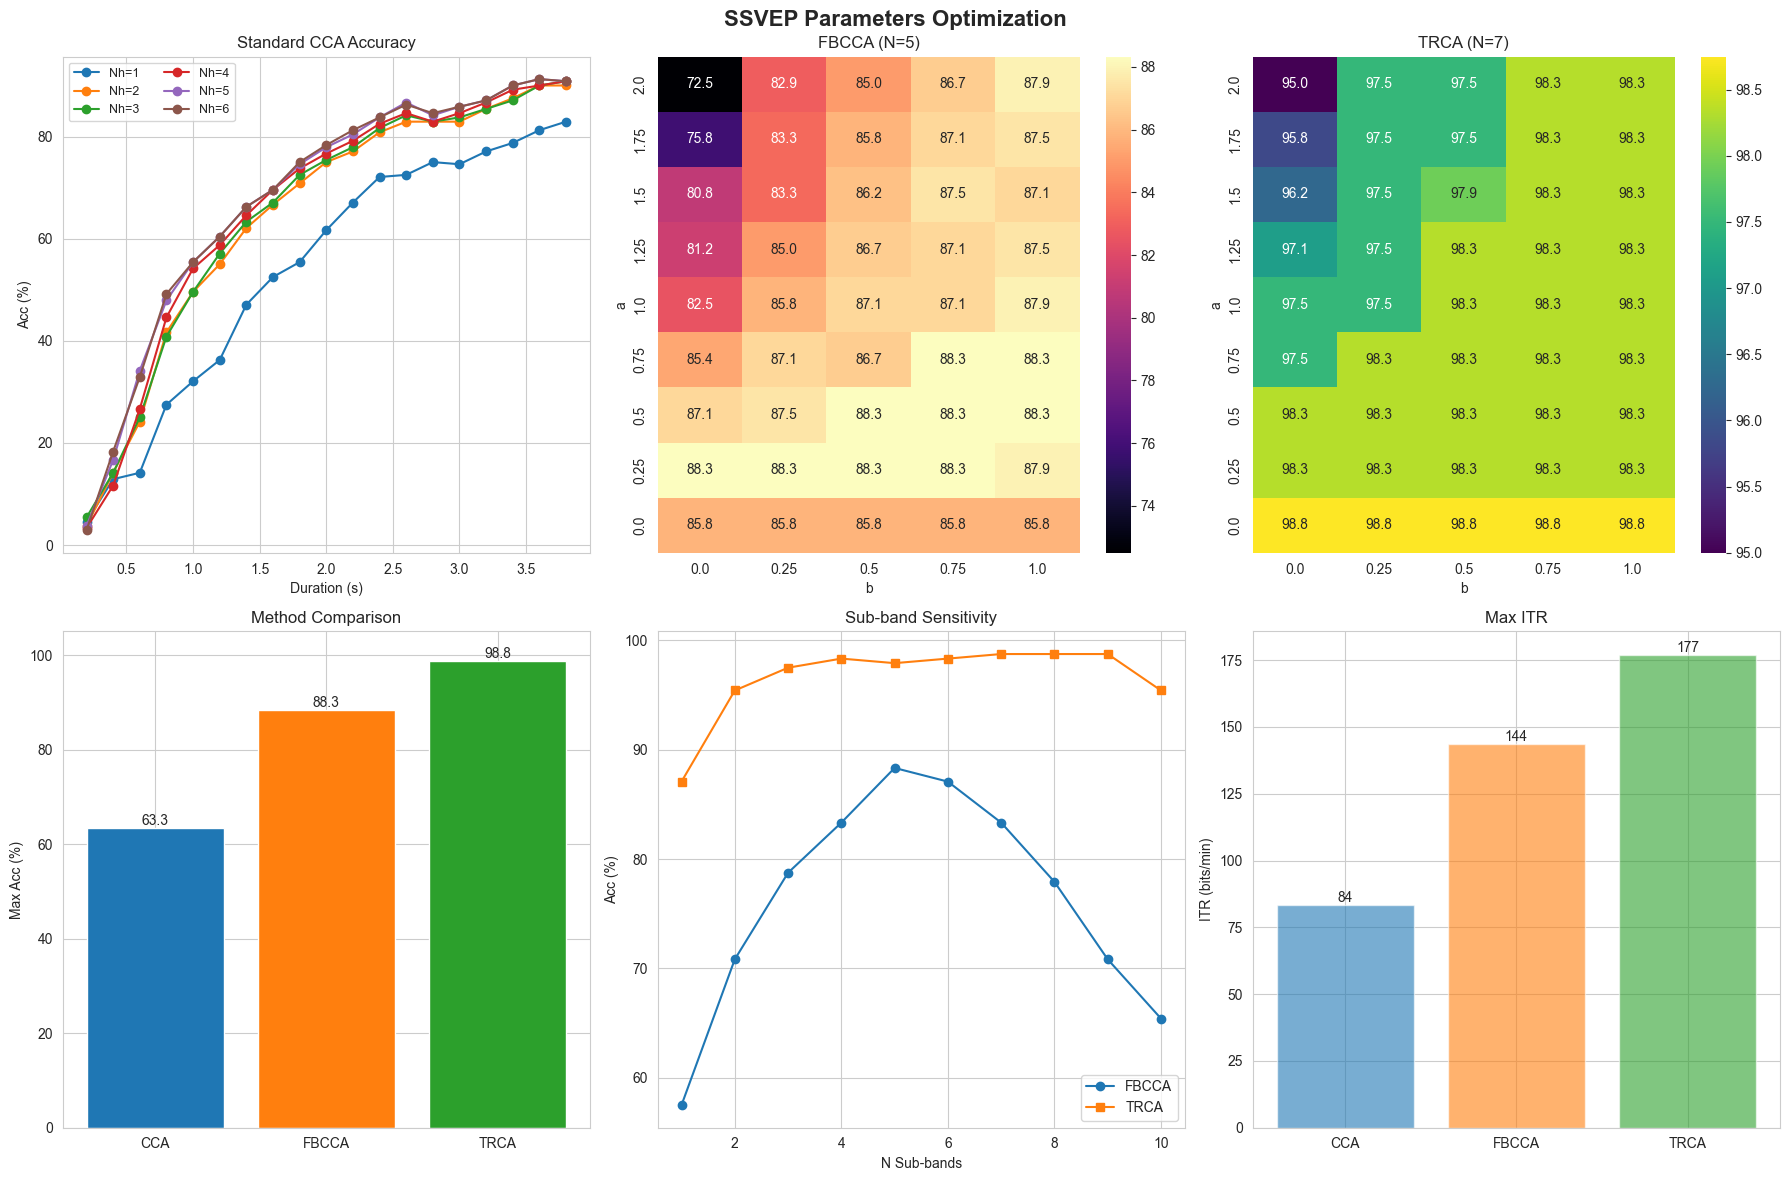

In [32]:
from src.visualization.cca_visualization import visualize_stages_sweep_results

# 可视化阶段结果
fig = visualize_stages_sweep_results(s0, s1, s2, s3, config=cfg,
                                     save_path='../image/ssvep_stages_sweep_results.png')

**Figure 3.4.2 固定时间窗口（1.25 s）条件下的算法深度优化与对比**
(a) CCA：谐波数扫描得到最优 $Nh=5$，准确率 63.3%

(b) FBCCA：网格搜索子带数与权重 $w_n=n^{-a}+b$，最优组合为 $N=5, a=0.25, b=0.0$，准确率 88.3%

(c) 集成TRCA：子带数与权重网格搜索得到最优组合为 $N=7, a=0.0$，准确率 98.8%，并获得最高ITR

该图用于刻画在固定时间窗口（1.25 s）下，各算法经过充分调参后所能达到的上限性能

| 方法            | 固定窗设置           | 优化超参数                    | 最优准确率（%） | 对应 ITR（bits/min）‡ |
| ------------- | --------------- | ------------------------ | -------: | ----------------: |
| CCA           | Duration=1.25 s | **Nh=5**                 | **63.3** |          ≈ **84** |
| FBCCA         | Duration=1.25 s | **N=5, a=0.25, b=0.0**   | **88.3** |         ≈ **144** |
| Ensemble TRCA | Duration=1.25 s | **N=7, a=0.0**（b 对结果不敏感） | **98.8** |         ≈ **177** |


## <center>Part IV 讨论</center>

### 4.1 为何“实验一 CCA/FBCCA 准确率很高”，但固定 1.25s 下 CCA 只有 63.3%？

这并不矛盾。扫描中的 **最佳准确率** 是在 **4–5 s** 的长窗口下取得的，此时频谱估计稳定且有效信噪比显著提升；而固定窗口实验，更考验算法对噪声与个体差异的鲁棒性。在 1.25 s 的短窗口下，CCA 仅依赖正弦参考信号，难以适应个体化的相位延迟与幅值比例，导致准确率大幅下降至 63.3%。FBCCA 通过子带分解与加权融合，部分缓解了这一问题，提升至 88.3%.

### 4.2 TRCA 的优势机制

TRCA 的关键并非“找到正确的频率”，而是“增强可重复的诱发成分并抑制非锁相噪声”，属于数据驱动的模板匹配方法。对于短时间窗口，学习到的模板通常比正弦参考更贴近真实的 SSVEP 响应（包含个体相位延迟、幅值比例、通道空间分布），因此能以更短的 Duration 达到更高的准确率，从而显著提高 ITR。

### 4.3 设计建议（面向在线 BCI）
*   若目标是 **最高 ITR**：根据扫描结果优先选择 TRCA，并选择 **0.8–1.0 s** 的时间窗口区间作为候选（需结合用户舒适度与误差代价）
*   若系统约束无法进行模板训练（无训练数据）：FBCCA 是更强的无监督替代方案，推荐使用 **H=5** 与中短时间窗口（约 1.0 s）区域
*   CCA 适合作为基线方法或快速验证，但其短窗口性能通常受限

## <center>Part V: 结论 </center>
本研究针对40类SSVEP脑机接口分类任务，系统性地对比了传统机器学习方法（SVM）与空间滤波方法（CCA、FBCCA、TRCA）的性能表现。主要结论如下：

### 方法性能对比

| 方法 | 最优准确率 | 最优ITR (bits/min) | 关键特性 |
|:----:|:----:|:----:|:----:|
| SVM（FFT特征） | 99.58% (5s) | ~63 | 依赖人工特征工程，长时窗 |
| CCA | 96.25% (4.8s) | 83 (1.4s) | 无监督，短窗口性能受限 |
| FBCCA | 99.58% (4.0s) | 128 (1.0s) | 子带分解增强谐波利用 |
| TRCA | 99.58% (4.6s) | **174 (0.8s)** | 数据驱动模板匹配，最高ITR |

### 核心发现

1. **Duration–Harmonics全景扫描**：准确率随时间窗口增长趋于饱和，而ITR在中短Duration（0.8–1.4s）处达到峰值，体现了速度与精度之间的权衡

2. **算法性能排序**：在短时间窗口（≤1.25s）条件下，TRCA >> FBCCA >> CCA，TRCA凭借其数据驱动的空间滤波机制，在0.8s窗口下仍保持98%以上准确率

3. **通道选择敏感性**：枕叶区域9通道组合（Pz, PO3, PO5, PO4, PO6, POz, O1, Oz, O2）在准确率与计算效率间取得最优平衡，全脑64通道反而因"维数灾难"导致性能下降

### 应用建议

- **高ITR场景**：优先采用TRCA，推荐0.8–1.0s时间窗口
- **无训练条件**：采用FBCCA（N=5, a=0.25, b=0.0）作为折中方案
- **基线验证**：CCA适合快速原型开发，但短窗口性能受限


### 后续工作
可以应用CNN或transformer等深度学习方法，结合时频特征与空间滤波，进一步提升SSVEP识别性能，并探索更短时间窗口下的高效解码策略，已有相关工作[1, 2]，取得了初步成果，笔者也尝试去复现 TRCA-net，初步成果在 kaggle 平台可以看到：https://www.kaggle.com/code/glitterjade/trca-net.

[1] Deng, Y., Sun, Q., Wang, C., Wang, Y., & Zhou, S. K. (2023). TRCA-Net: using TRCA filters to boost the SSVEP classification with convolutional neural network. Journal of neural engineering, 20(4), 10.1088/1741-2552/ace380. https://doi.org/10.1088/1741-2552/ace380

[2] Chen, J., Zhang, Y., Pan, Y., Xu, P., & Guan, C. (2022). A Transformer-based deep neural network model for SSVEP classification. Neural networks : the official journal of the International Neural Network Society, 164, 521-534.

以上代码全部保存在 GitHub 仓库中：https://github.com/UniqJade/AI4BrainScience